# Machine Learning Project
## Mbusu-Team

### **House Prices Dataset**

### **Data Understanding**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sb
from scipy.stats import entropy
import math
import sys
from itertools import groupby
plt.style.use('ggplot')


hue_order = ["HIGH","MEDIUM","LOW"]
color = ["#BF4E30","#2E86AB","#E7A012"]
palette = {
    'LOW': color[0],
    'MEDIUM': color[1],
    'HIGH': color[2],
}
TARGET_FEATURE = 'SalePrice'
TARGET_FEATURE_CONTI = 'salePriceNum'
TARGET_FEATURE_VALUES = ['LOW', 'MEDIUM', 'HIGH']

#### Utils

###### INFORMATION GAIN FUNTION 

In [4]:
def IG(df, target, attribute):

    df_sub = []

    for value in df[attribute].unique():
        df_sub.append( df[df[attribute] == value] )
        
    counts = df[target].value_counts()
    probs = counts / len(df)
    e = -np.sum(probs * np.log2(probs))

    information_gain = e 
    for df_s in df_sub:
        counts = df_s[target].value_counts()
        probs = counts / len(df_s)
        e_s = -np.sum(probs * np.log2(probs))
        information_gain -= len(df_s) / len(df) * e_s

    return information_gain


###### Mean

In [5]:
def mean_attribute(df, attribute):
    mean_low = df[ ( df["SalePrice"] == 'LOW' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    mean_medium = df[ ( df["SalePrice"] == 'MEDIUM' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    mean_high = df[ ( df["SalePrice"] == 'HIGH' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    return (mean_low, mean_medium, mean_high)



###### Set means

In [6]:
def set_means(df,attribute):
    mean_values = mean_attribute(df,attribute)

    for ind , e  in df.iterrows():
        if e[attribute] == "NA":
            if(e["SalePrice"] == "LOW"):
                df.at[ind, attribute] = mean_values[0]
            elif e["SalePrice"] == "MEDIUM":
                df.at[ind, attribute] = mean_values[1]
            else:
                df.at[ind, attribute] = mean_values[2]


    df[attribute] = df[attribute].astype("int")


###### Plot frequencies and percentages

In [7]:
def frequencies_and_percentages(df, target, attribute):
    fig, ax = plt.subplots(1,2, figsize=(15,5))

    dfp = df[[attribute,target]].pivot_table(index = attribute, columns=[target],  aggfunc=len)
    dfp = dfp.fillna(0)
    dfpp = dfp.pipe(lambda d : 100*d.div(sum(d[v] for v in df[target].unique()), axis='index'))
    display(dfpp)
    dfp.plot(kind='bar', ax=ax[0]  , title = f"Count by {attribute}" ,  color = color )
    dfpp.plot(kind='bar',ax=ax[1] , stacked=True , title  = f"Percentage by {attribute}", legend = False , color = color )

###### Histplot

In [8]:

def histplot(df,target, attribute, bins = None , figsize=(15,5), xticks_rot=0):
    if bins is None:
        bins = len(df)
    plt.figure(figsize = figsize)
    sb.histplot(x = df[attribute], hue = target, data = df, kde=True , hue_order = hue_order, palette = palette, bins = bins , common_bins= False)
    plt.xticks(rotation=xticks_rot)
    plt.show()

###### indepence_test_categoric

In [68]:

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]
    
def label_group_bar_table(ax, df):
    ypos = -.05
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            if pos % 3 == 0: add_line(ax, pos*scale, ypos - .052)
            pos += rpos
        add_line(ax, pos*scale , ypos - .052)
        ypos -= .05

def barplot_diffvalues(dataset, feature_name):
    df = dataset.reset_index().groupby([feature_name, TARGET_FEATURE]).sum()
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    #print(dataset)
    dataset.pivot_table(index = [feature_name, TARGET_FEATURE], columns=['__Type']).plot(kind='bar', ax=ax, width=.7)
    
    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_title('Expected/Observed Frequencies')
    ax.set_xlabel(f'{feature_name}/{TARGET_FEATURE}', labelpad=40)
    ax.set_ylabel(f'{TARGET_FEATURE}')
    plt.legend(['Expected', 'Observed'])
    label_group_bar_table(ax, df)

    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    plt.show()

def stattest_quali(df, feature_name: str, fig_width=15, fig_height=3, typeplot = 'heatmap', silent: bool=False):

    #
    # chi-square test and expected frequencies matrix
    #
    crosstab = pd.crosstab(df[feature_name], df[TARGET_FEATURE])
    chi_square_args = crosstab.values
    _, p_value, _, _ = stats.chi2_contingency(chi_square_args)

    expf_crosstab = pd.DataFrame(crosstab)
    for idx in expf_crosstab.index:
        for col in expf_crosstab.columns:
            expf_crosstab.at[idx, col] = crosstab.loc[idx].values.sum() * crosstab[col].values.sum() / crosstab.values.sum()

    if not silent:
        #
        # observed/expected frequencies heatmaps
        #
        fig_width = min(fig_width, 1.5 * len(df[feature_name].unique()))
        fig, ax = plt.subplots(2, 1, figsize=(fig_width, fig_height * 2))
        sb.heatmap(crosstab.T, ax=ax[0], annot=True, cmap='coolwarm', fmt='.2f')
        sb.heatmap(expf_crosstab.T, ax=ax[1], annot=True, cmap='coolwarm', fmt='.2f')
        ax[0].set_title('Observed Frequencies')    
        ax[1].set_title('Expected Frequencies')
        fig.tight_layout()
        plt.show()

        if(typeplot == 'heatmap'):
            
            #
            # frequencies difference heatmap
            #
            obsexp_diff_df = crosstab - expf_crosstab
            fig = plt.figure(figsize=(fig_width, fig_height))
            plt.title("Frequency Differences (Observed - Expected)")
            sb.heatmap(obsexp_diff_df.T, annot=True, cmap='vlag', fmt='.2f')
        
        elif typeplot == 'barplot':
            #
            # observed/expected frequencies barplot
            #
            value_vars_x = [val + '_x' for val in TARGET_FEATURE_VALUES]
            value_vars_y = [val + '_y' for val in TARGET_FEATURE_VALUES]
            value_vars_xy = value_vars_x + value_vars_y
            obs_exp_df = pd.merge(crosstab, expf_crosstab, on=[feature_name]).reset_index()
            obs_exp_df = pd.melt(obs_exp_df, id_vars=[feature_name], value_vars=value_vars_xy)
            obs_exp_df['__Type'] = obs_exp_df[TARGET_FEATURE]

            for val in value_vars_x: obs_exp_df.loc[obs_exp_df['__Type'] == val, '__Type'] = '__OBS'
            for val in value_vars_y: obs_exp_df.loc[obs_exp_df['__Type'] == val, '__Type'] = '__EXP'

            for price in TARGET_FEATURE_VALUES:
                for obs_exp in ['x', 'y']:
                    obs_exp_df.loc[obs_exp_df[TARGET_FEATURE] == price + '_' + obs_exp, TARGET_FEATURE] = price[0]

            barplot_diffvalues(obs_exp_df, feature_name)

    #
    # chi-square test outcome
    #
    p_value_info = '[<0.05]' if p_value < 0.05 else ''
    if not silent:
        print("Chi-square Test - Outcome")
        print("P-Value:", p_value, p_value_info)
    return p_value, p_value_info

###### indepence_test_numeric

In [10]:
def stattest_quanti(df, feature_name: str, target = TARGET_FEATURE ,low_limit=0, upper_limit=100):

    #
    # plot means w.r.t. target categories
    #
    df_conti_origin = df[[feature_name, target, TARGET_FEATURE_CONTI]] if ( target == TARGET_FEATURE) else None
    df_categ_origin = df[[feature_name, target]]
    df = df_categ_origin.groupby(target)
    mean_df = df.mean().reset_index().rename(columns={feature_name: feature_name + ' (AVG)'})

    num = 3
    if df_conti_origin is None:
        num = 2
    _, ax = plt.subplots(1, num, figsize=(20, 5))

    mean_df.plot(kind='bar', x=target, ax=ax[0])
    for container in ax[0].containers:
        ax[0].bar_label(container, fmt='%.1f')
    ax[0].set_ylim(low_limit, upper_limit)
    ax[0].tick_params(labelrotation=0)

    sb.histplot(x=feature_name, hue=target, data=df_categ_origin, kde=True, ax=ax[1])
    for tval in TARGET_FEATURE_VALUES:
        ax[1].axvline(x=df_categ_origin[df_categ_origin[target] == tval][feature_name].mean(), color='gray', ls='--', lw=1.5)
    
    if df_conti_origin is not None : sb.regplot(x=feature_name, y=TARGET_FEATURE_CONTI, data=df_conti_origin, line_kws={"color": "darkred"}, ax=ax[2])
    
    #
    # perform ANOVA test
    #
    anova_args = tuple(df[feature_name].apply(list).reset_index()[feature_name])
    f_statistic, p_value = stats.f_oneway(*anova_args)

    p_value_info = '[<0.05]' if p_value < 0.05 else ''
    print("ANOVA Test - Outcome")
    print("P-Value:", p_value, p_value_info)

###### Numeric Numeric Correlation

In [11]:
def correlation(df, n1, n2):

    sb.regplot(x=n1, y=n2, data=df, line_kws={"color": "darkred"})
    
    corr, p_values = stats.pearsonr(df[n1], df[n2])
    
    print(corr, p_values)

###### Categoric Ordinal Plots & Stattest

In [12]:
def categoric_ordinal_plot(df, attr, test_typeplot='heatmap'):
    df2 = df.copy(deep=True)

    attr_values = df2[attr].unique().tolist()
    df2[attr] = df2[attr].astype('object')
    for val in attr_values: df2.loc[df2[attr] == val, attr] = attr + '_' + str(val)
    df2[attr] = df2[attr].astype('category')

    frequencies_and_percentages(df2, TARGET_FEATURE, attr)
    stattest_quali(df2, attr, typeplot=test_typeplot)
    print(IG(df, TARGET_FEATURE, attr))

#### Read data

In [13]:
df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv', keep_default_na = False, low_memory= False )
df["salePriceNum"] = df.SalePrice.rename("salePriceNum")
df["SalePrice"] = pd.cut(df["salePriceNum"], bins = [0,150000,300000 - 1 ,int(sys.maxsize)], labels=["LOW","MEDIUM","HIGH"])
df_copy = df.copy(deep=True)

In [14]:
df.shape

(1460, 82)

In [15]:
df.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,salePriceNum
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### View Data

In [16]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,salePriceNum
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,NA,0,2,2008,WD,Normal,MEDIUM,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,NA,0,5,2007,WD,Normal,MEDIUM,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,NA,0,9,2008,WD,Normal,MEDIUM,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,NA,0,2,2006,WD,Abnorml,LOW,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,NA,0,12,2008,WD,Normal,MEDIUM,250000


#### Info data

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   int64   
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1460 non-null   object  
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          1460 non-null   object  
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   in

#### Classes

In [18]:
df.SalePrice.unique()

['MEDIUM', 'LOW', 'HIGH']
Categories (3, object): ['LOW' < 'MEDIUM' < 'HIGH']

#### Undestanding the effect of the attributes

##### ID

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1.00000000e+00, 1.99931507e+00, 2.99863014e+00, ...,
        1.45800137e+03, 1.45900068e+03, 1.46000000e+03]),
 <BarContainer object of 1460 artists>)

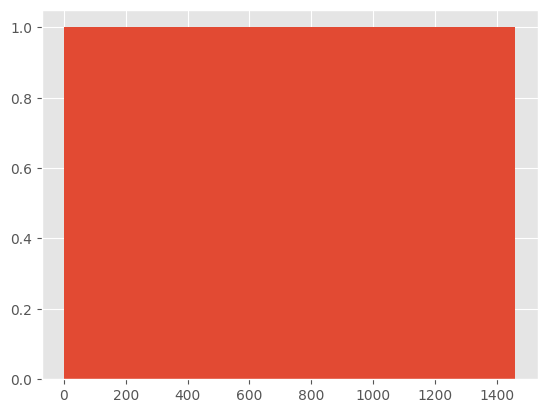

In [19]:
plt.hist(df["Id"], bins= len(df))

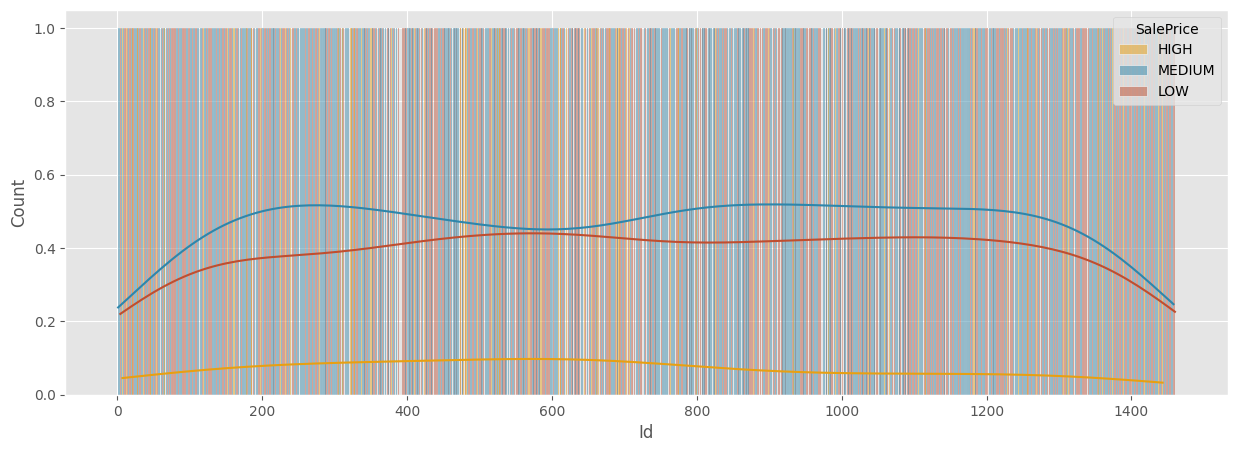

In [20]:
histplot(df,'SalePrice',"Id")

In [21]:
print("Max Entropy ( Log n ) -> " + str(math.log(len(df), 2)))

counts = df['Id'].value_counts()
probs = counts / len(df)
e = -np.sum(probs * np.log2(probs))
print("Entropy -> "+ str(e))

Max Entropy ( Log n ) -> 10.51175265376738
Entropy -> 10.511752653767381


##### MSSubClass

In [22]:
df["MSSubClass"] = df["MSSubClass"].astype("category")

SalePrice,LOW,MEDIUM,HIGH
MSSubClass,,,
20,43.097015,47.761194,9.141791
30,97.101449,2.898551,0.000000
40,50.000000,50.000000,0.000000
45,100.000000,0.000000,0.000000
50,72.222222,25.000000,2.777778
60,2.006689,80.936455,17.056856
70,45.000000,51.666667,3.333333
75,43.750000,43.750000,12.500000
80,29.310345,68.965517,1.724138


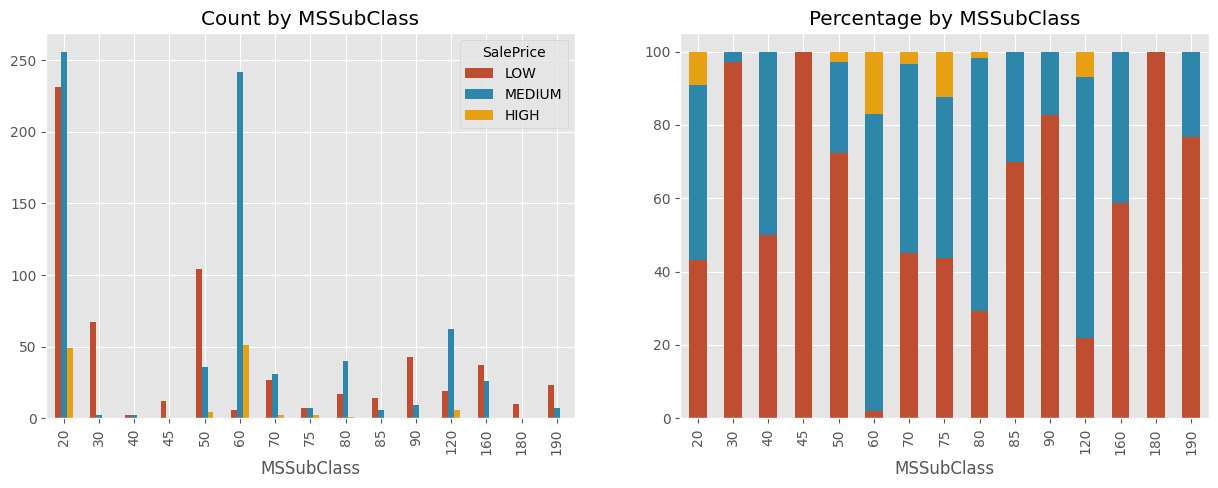

In [23]:
frequencies_and_percentages(df, 'SalePrice', 'MSSubClass')

In [24]:
IG(df,"SalePrice","MSSubClass")

c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.28611883641757957

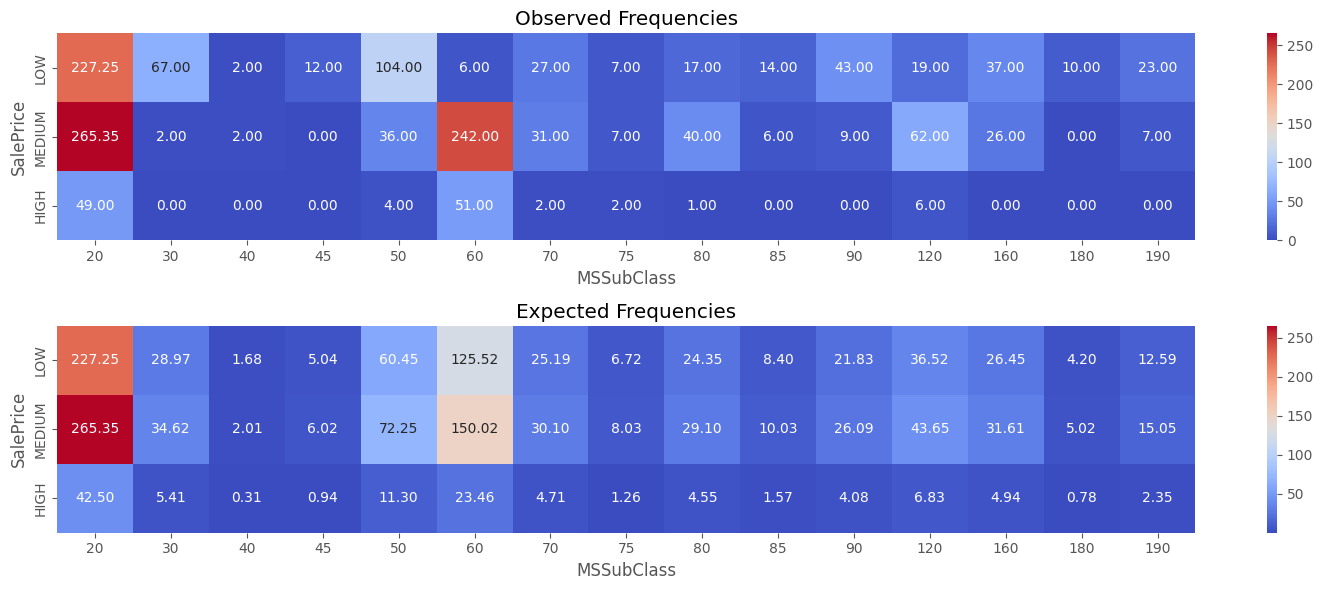

Chi-square Test - Outcome
P-Value: 1.122234664911419e-81 [<0.05]


(1.122234664911419e-81, '[<0.05]')

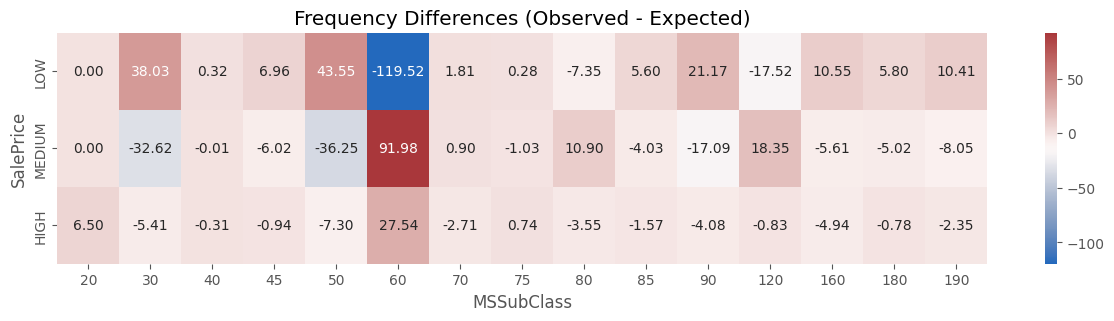

In [25]:
# Indepence test

stattest_quali(df, 'MSSubClass')

##### HouseStyle

SalePrice,LOW,MEDIUM,HIGH
HouseStyle,,,
1.5Fin,71.428571,25.974026,2.597403
1.5Unf,100.000000,0.000000,0.000000
1Story,47.382920,45.041322,7.575758
2.5Fin,25.000000,62.500000,12.500000
2.5Unf,63.636364,27.272727,9.090909
2Story,20.224719,67.865169,11.910112
SFoyer,78.378378,21.621622,0.000000
SLvl,35.384615,63.076923,1.538462


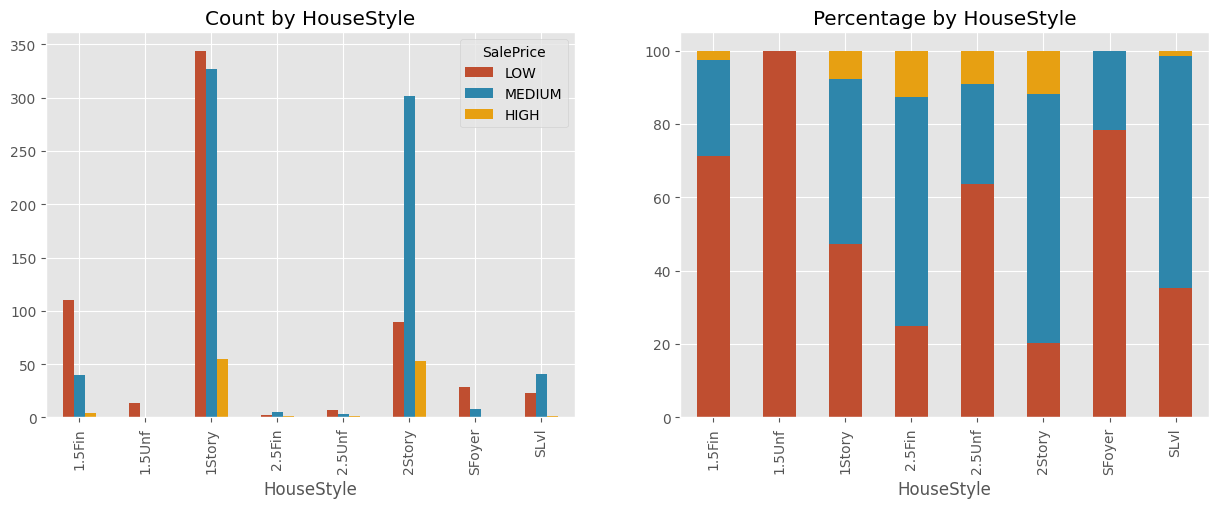

In [26]:
frequencies_and_percentages(df, 'SalePrice', 'HouseStyle')

##### MSZoning

In [27]:
df["MSZoning"] = df["MSZoning"].astype("category")

In [28]:
IG(df, "MSZoning", "SalePrice")


c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.12336354296168264

<AxesSubplot:>

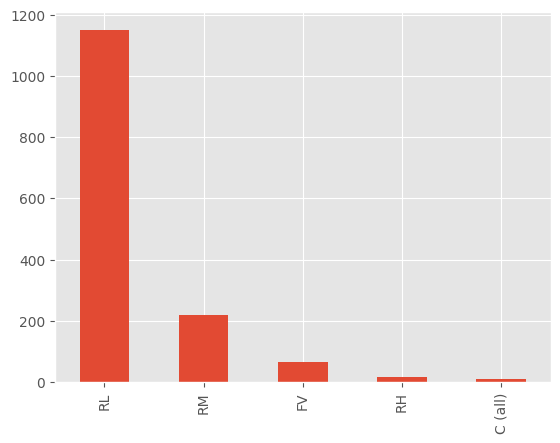

In [29]:
df["MSZoning"].value_counts().plot(kind="bar")

SalePrice,LOW,MEDIUM,HIGH
MSZoning,,,
C (all),100.000000,0.000000,0.000000
FV,6.153846,84.615385,9.230769
RH,75.000000,25.000000,0.000000
RL,35.708080,55.082537,9.209383
RM,83.486239,15.137615,1.376147


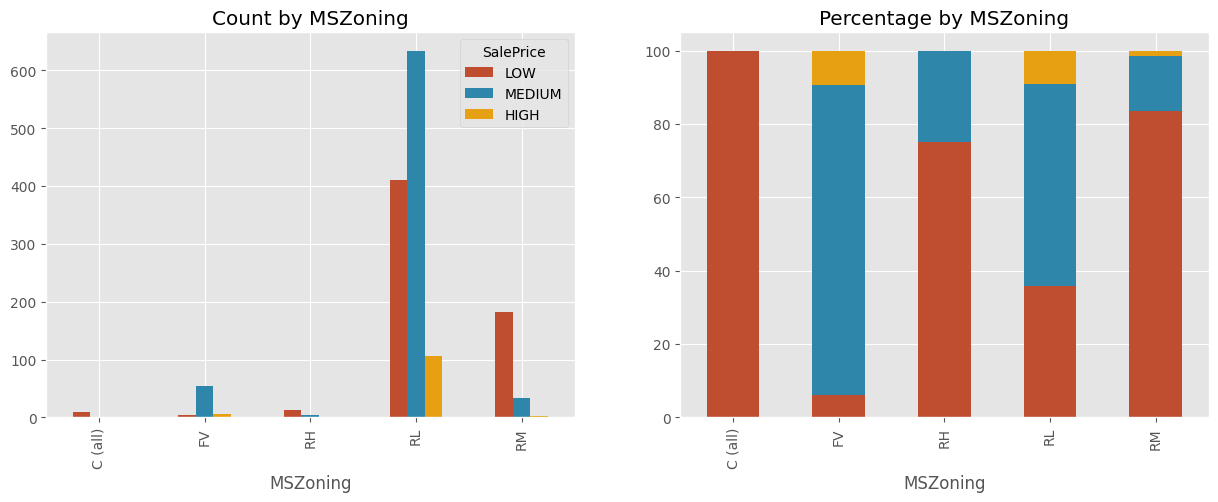

In [30]:
frequencies_and_percentages(df, 'SalePrice', 'MSZoning')

##### YearBuilt

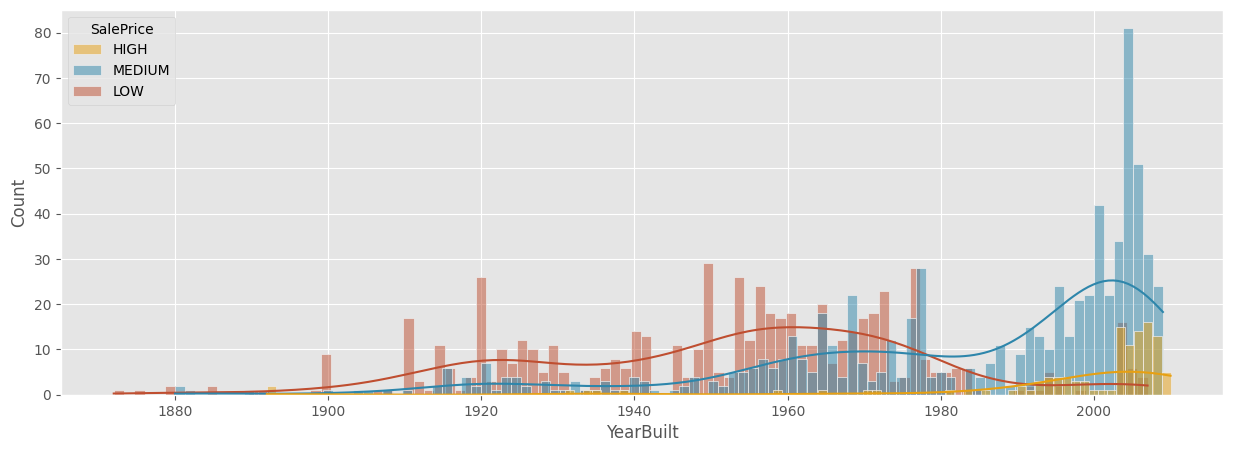

In [31]:
histplot(df,'SalePrice',"YearBuilt",bins=100)
    

ANOVA Test - Outcome
P-Value: 3.6397089066086615e-118 [<0.05]


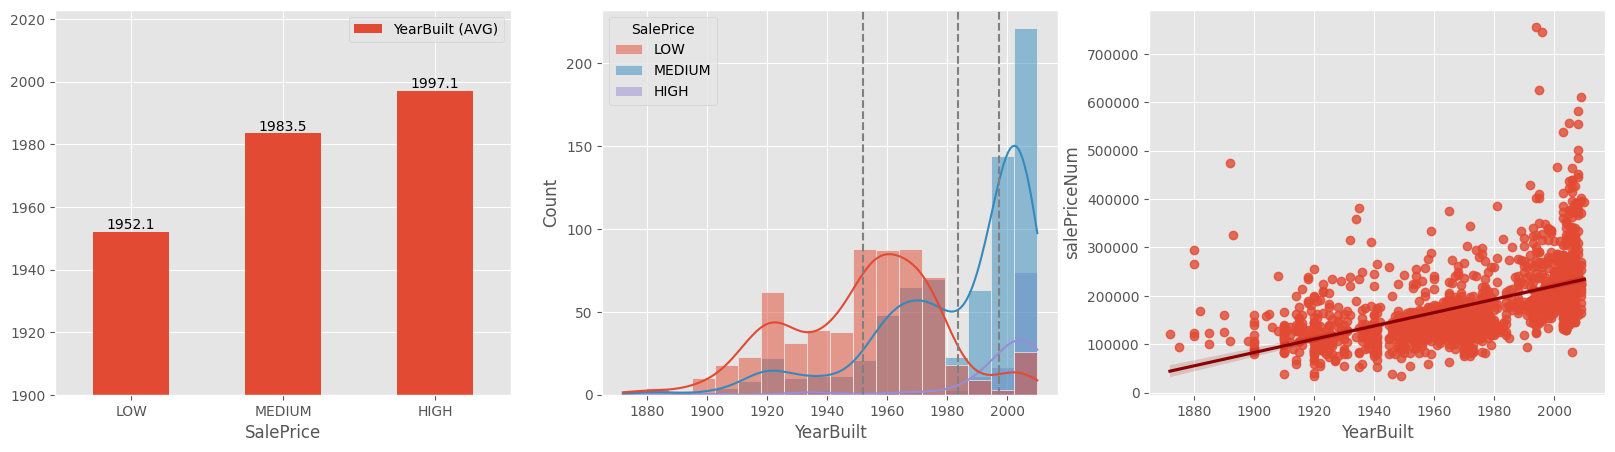

In [32]:
stattest_quanti(df,'YearBuilt', low_limit=1900, upper_limit=2023)

##### LotFrontage

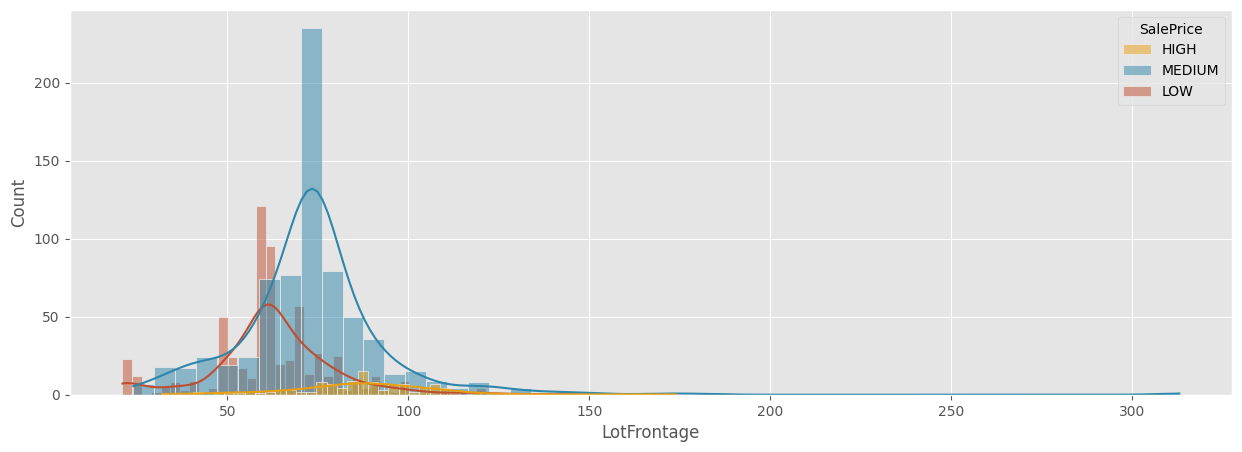

In [33]:
set_means(df,'LotFrontage')


histplot(df,'SalePrice',"LotFrontage", bins=50)


##### CentralAir

In [34]:
IG(df,'SalePrice','CentralAir')

c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.05543545701641375

SalePrice,LOW,MEDIUM,HIGH
CentralAir,,,
N,91.578947,8.421053,0.000000
Y,38.974359,52.600733,8.424908


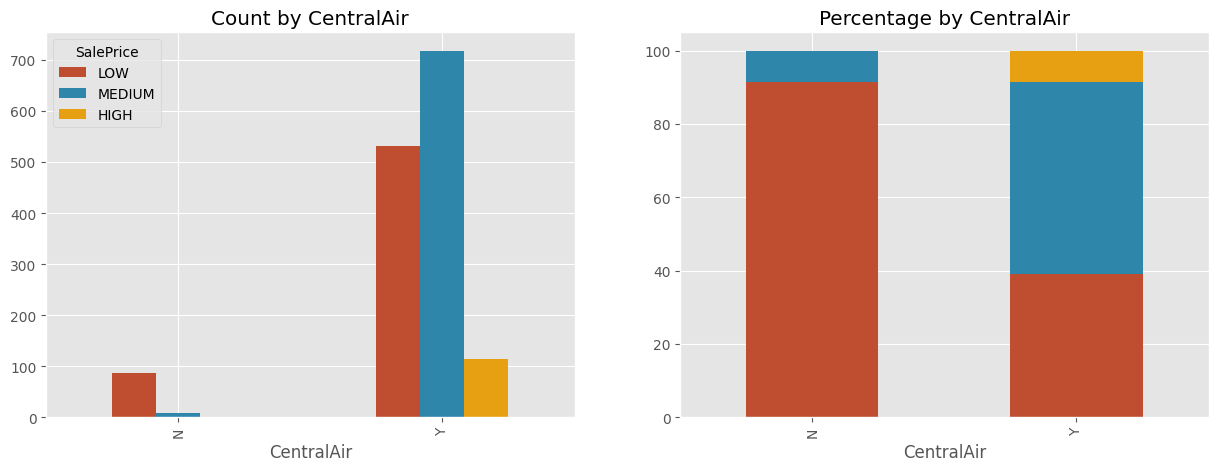

In [35]:
frequencies_and_percentages(df,'SalePrice','CentralAir')

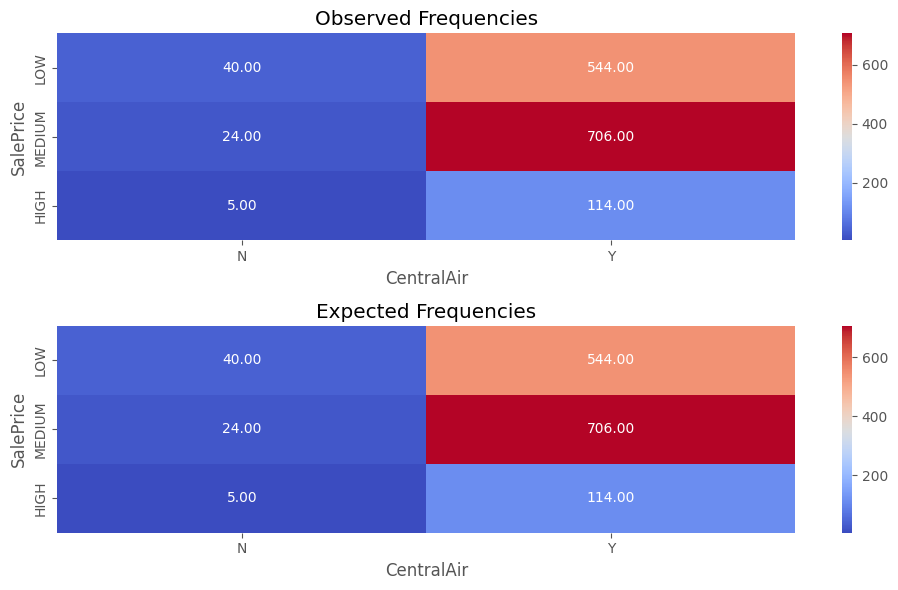

Chi-square Test - Outcome
P-Value: 1.2685848517032062e-22 [<0.05]


(1.2685848517032062e-22, '[<0.05]')

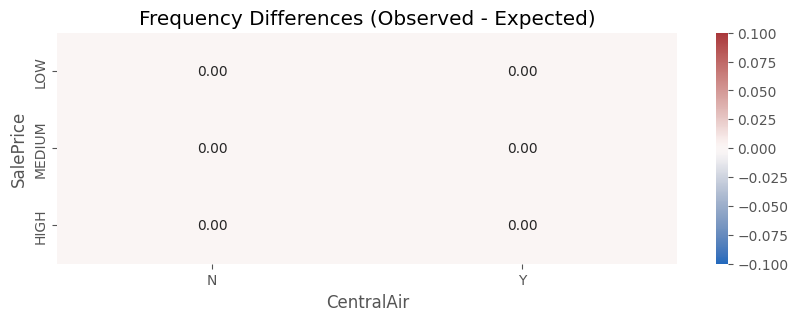

In [36]:
stattest_quali(df,'CentralAir', typeplot='heatmap', fig_width=10)

ANOVA Test - Outcome
P-Value: 7.00278021431306e-52 [<0.05]


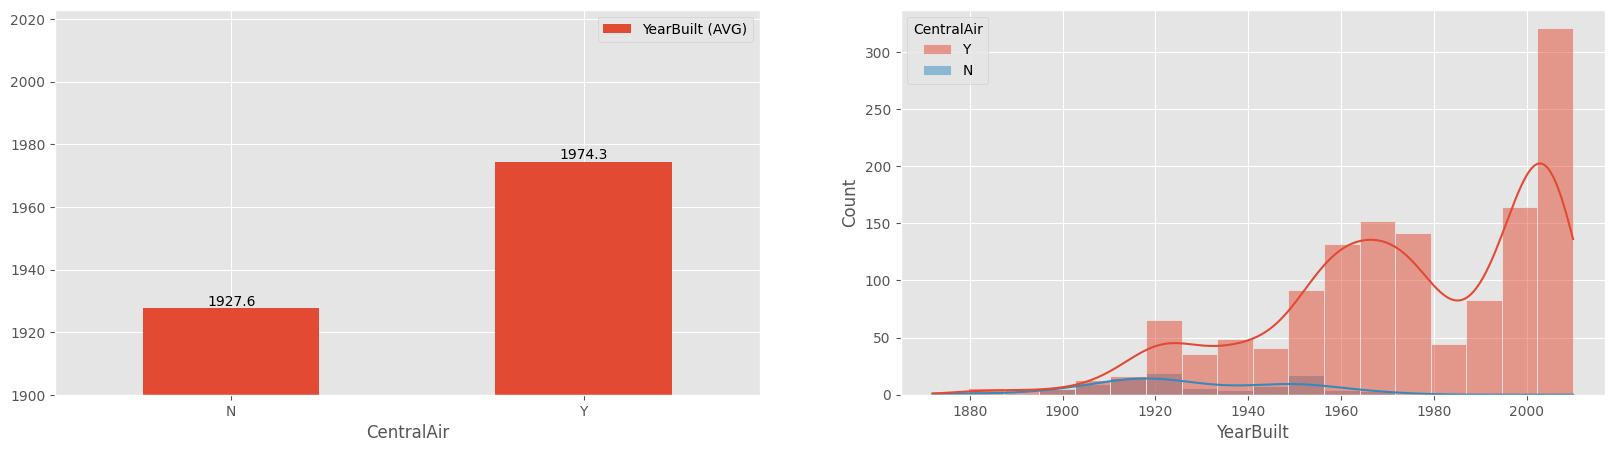

In [37]:
stattest_quanti(df,'YearBuilt', 'CentralAir' , low_limit=1900, upper_limit=2023)

##### Electrical

SalePrice,LOW,MEDIUM,HIGH
Electrical,,,
FuseA,81.914894,18.085106,0.00000
FuseF,96.296296,3.703704,0.00000
FuseP,100.000000,0.000000,0.00000
Mix,100.000000,0.000000,0.00000
NA,0.000000,100.000000,0.00000
SBrkr,38.380810,52.998501,8.62069


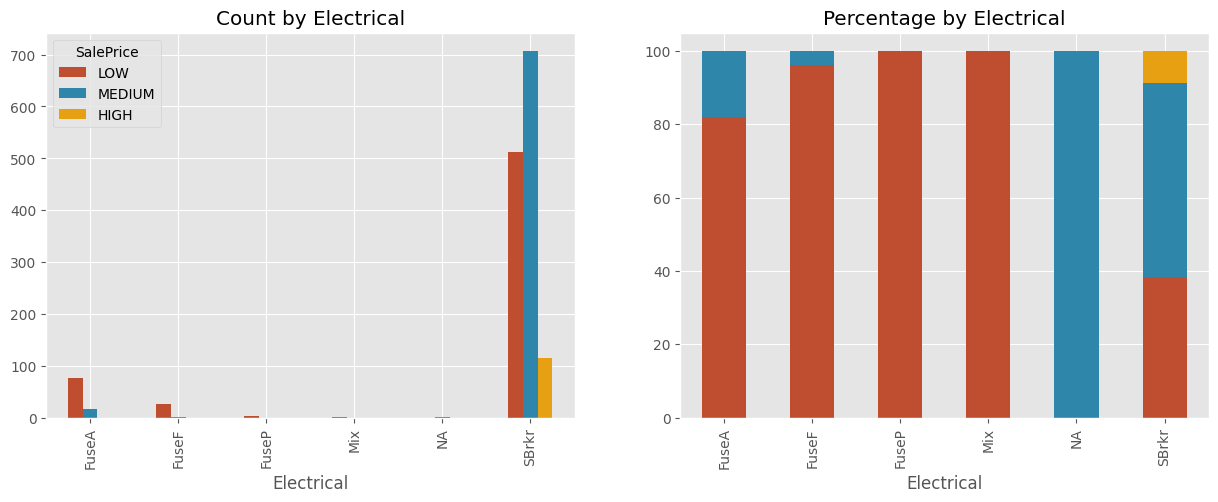

In [38]:
frequencies_and_percentages(df,'SalePrice','Electrical')

In [39]:
IG(df,'SalePrice','Electrical')

c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.060141516515176886

In [40]:
len(df[df['Electrical'] == 'NA'])

1

##### 1stFlrSF

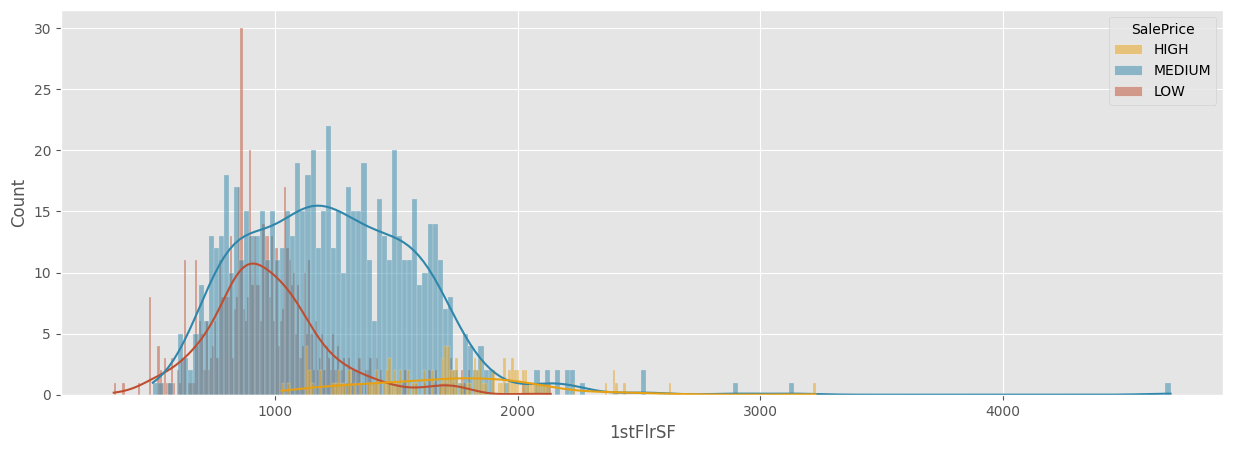

In [41]:
histplot(df,'SalePrice','1stFlrSF',bins=200)

ANOVA Test - Outcome
P-Value: 2.555821024618768e-104 [<0.05]


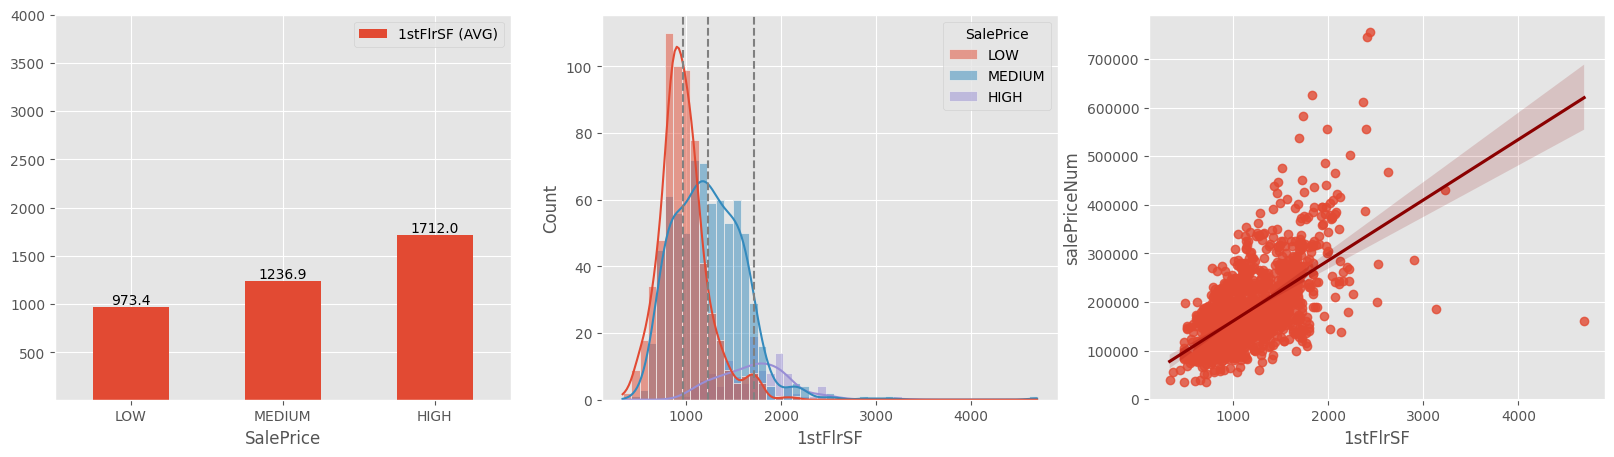

In [42]:
stattest_quanti(df,'1stFlrSF',low_limit=10, upper_limit=4000)

##### 2ndFlrSF


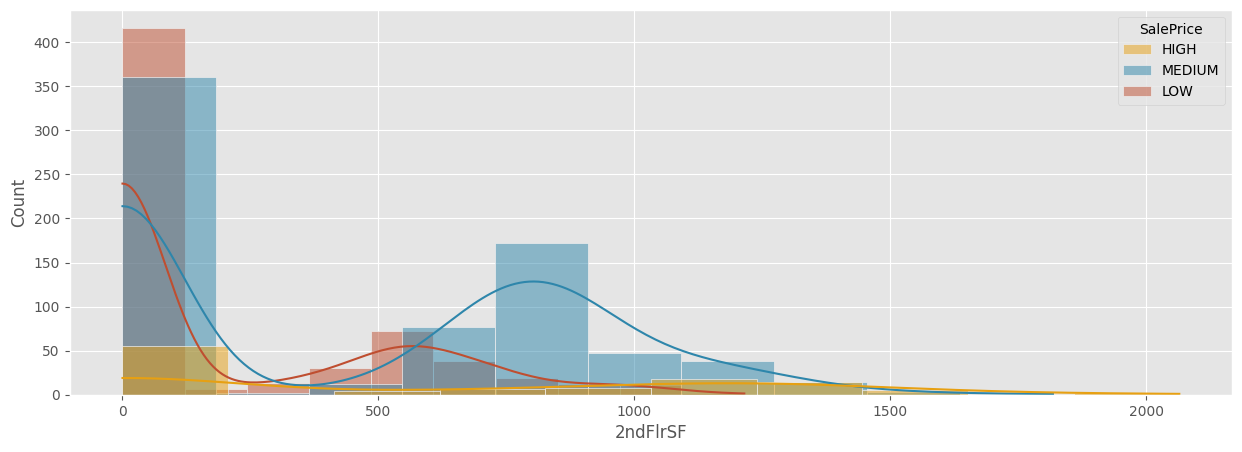

ANOVA Test - Outcome
P-Value: 1.7788644017519046e-32 [<0.05]


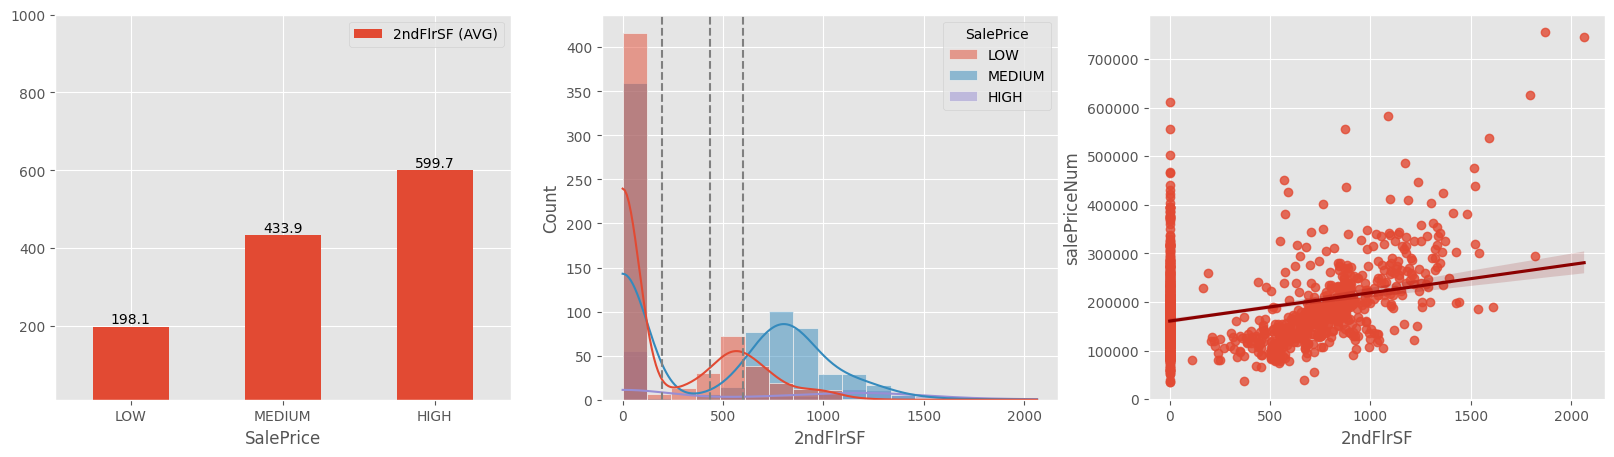

In [43]:
histplot(df,'SalePrice','2ndFlrSF',bins=10)
stattest_quanti(df,'2ndFlrSF',low_limit=10, upper_limit=1000)

##### LowQualFinSF

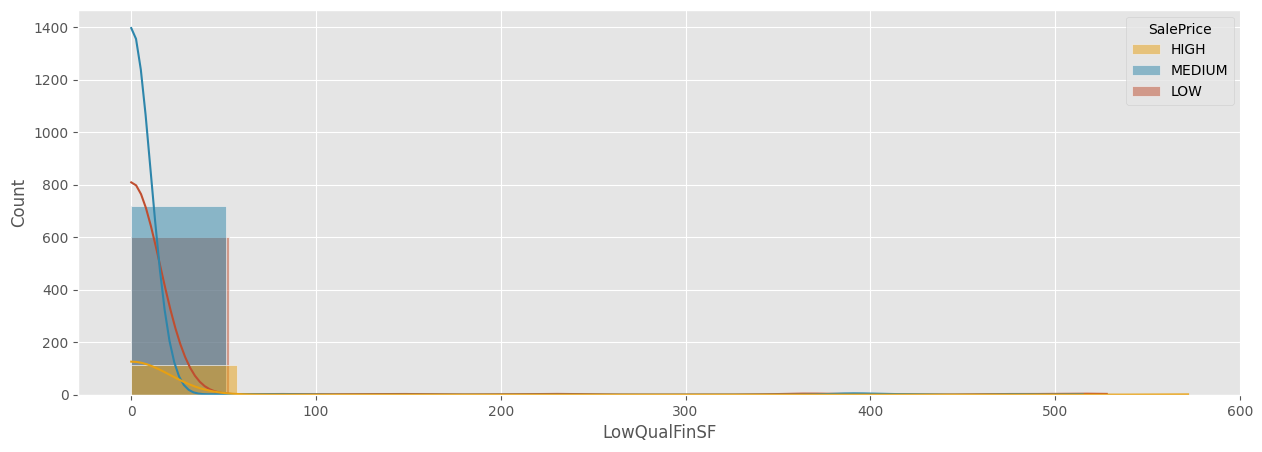

ANOVA Test - Outcome
P-Value: 0.20310425163833182 


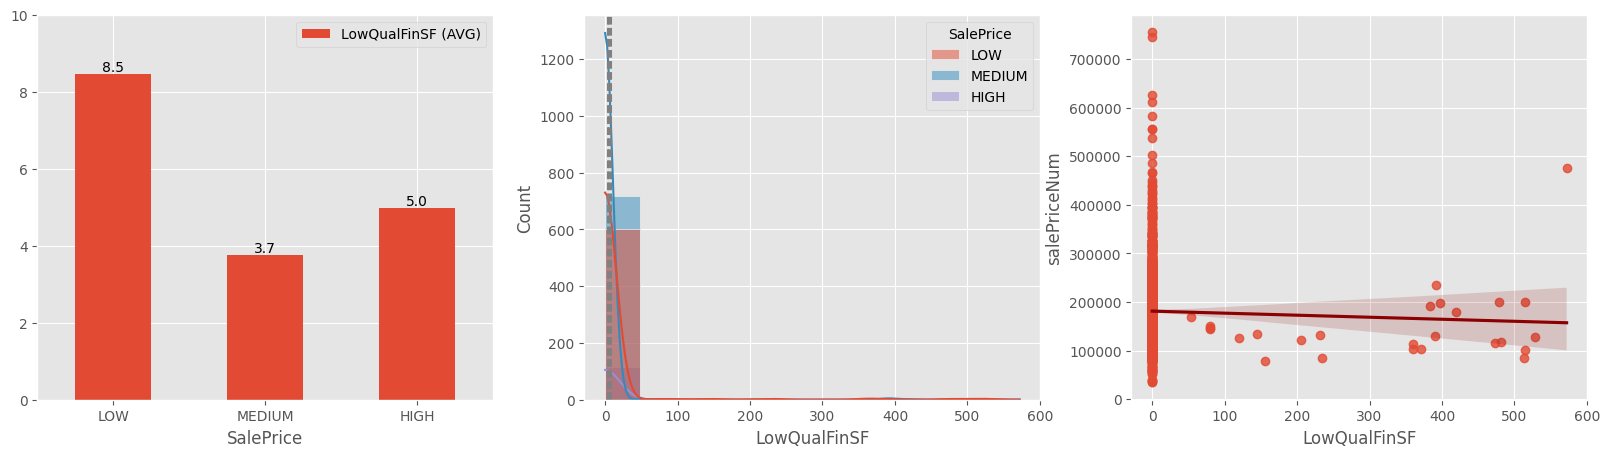

In [44]:
histplot(df,'SalePrice','LowQualFinSF',bins=10)
stattest_quanti(df,'LowQualFinSF',low_limit=0, upper_limit=10)

##### GrLivArea

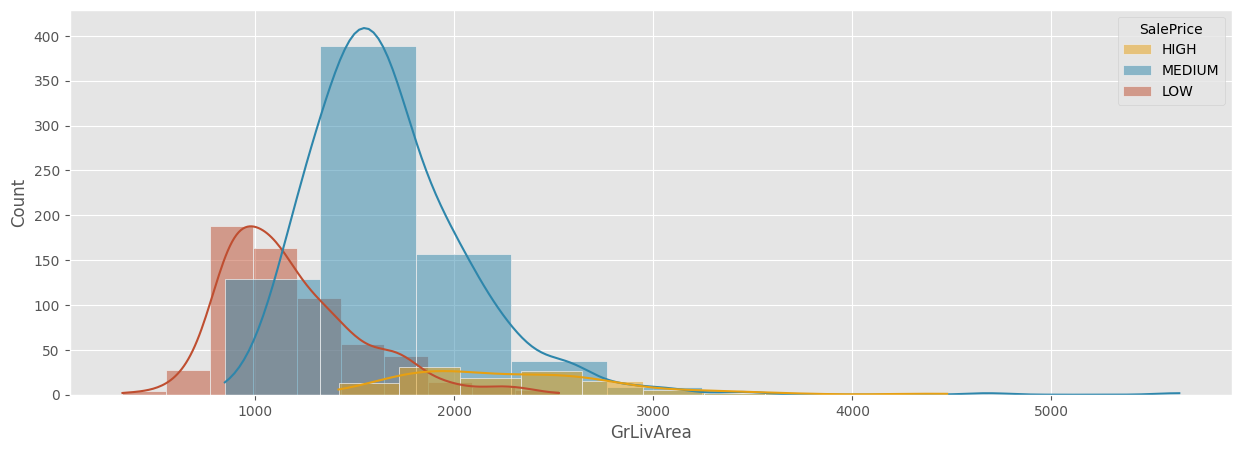

ANOVA Test - Outcome
P-Value: 2.727682408446856e-163 [<0.05]


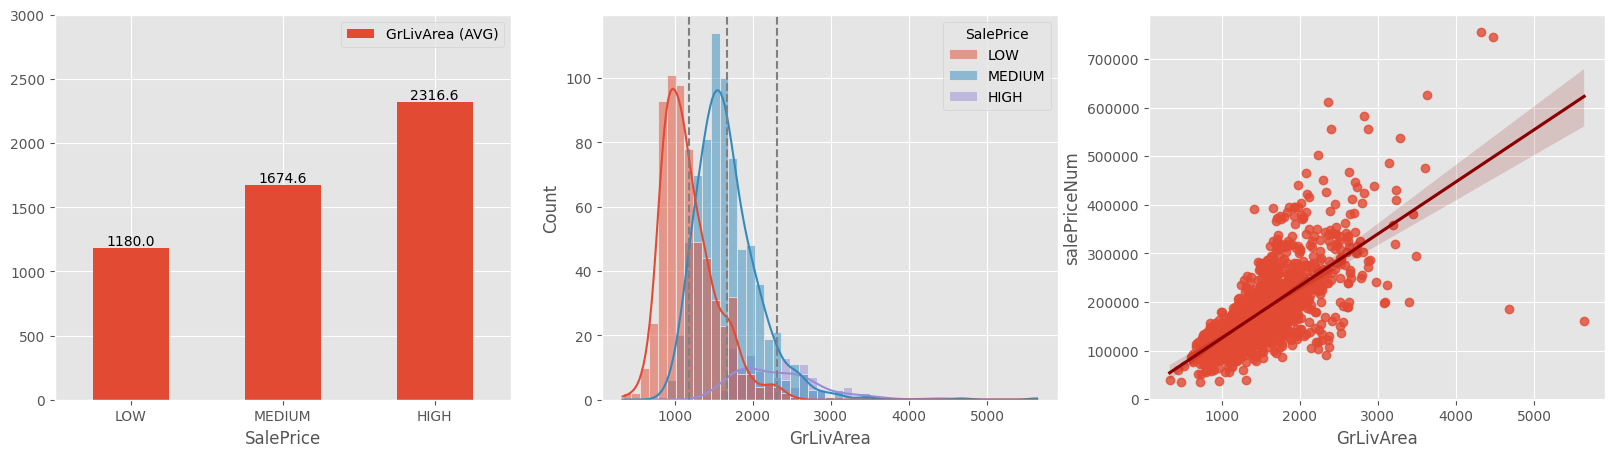

In [45]:
histplot(df,'SalePrice','GrLivArea',bins=10)
stattest_quanti(df,'GrLivArea',low_limit=0, upper_limit=3000)

##### BsmtFullBath

SalePrice,LOW,MEDIUM,HIGH
BsmtFullBath,,,
BsmtFullBath_0,48.130841,48.247664,3.621495
BsmtFullBath_1,34.353741,51.870748,13.775510
BsmtFullBath_2,33.333333,46.666667,20.000000
BsmtFullBath_3,0.000000,100.000000,0.000000


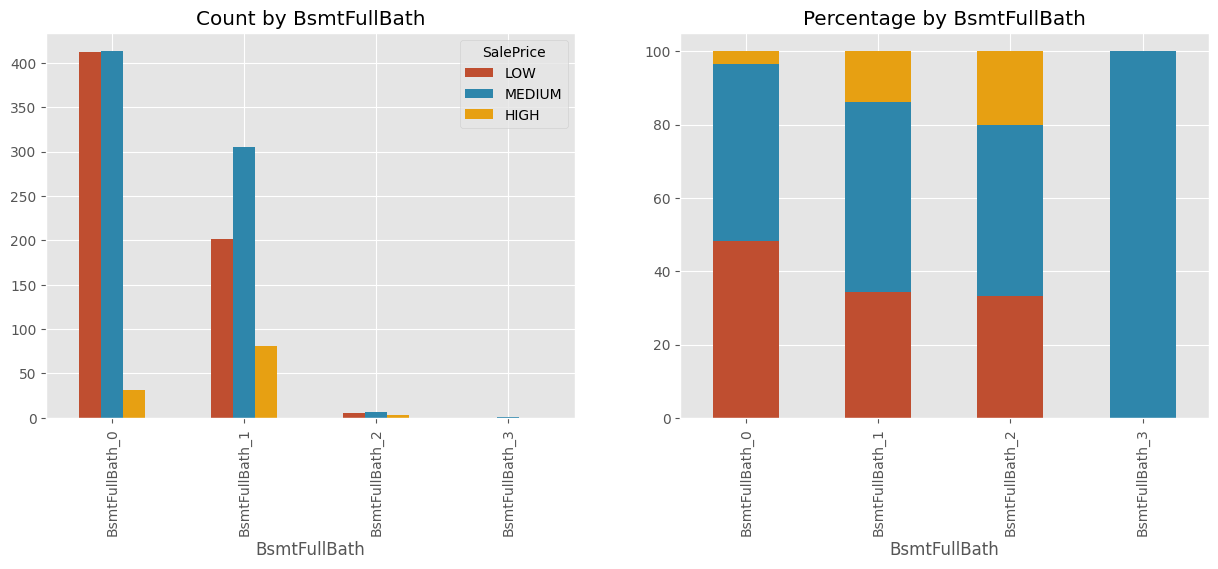

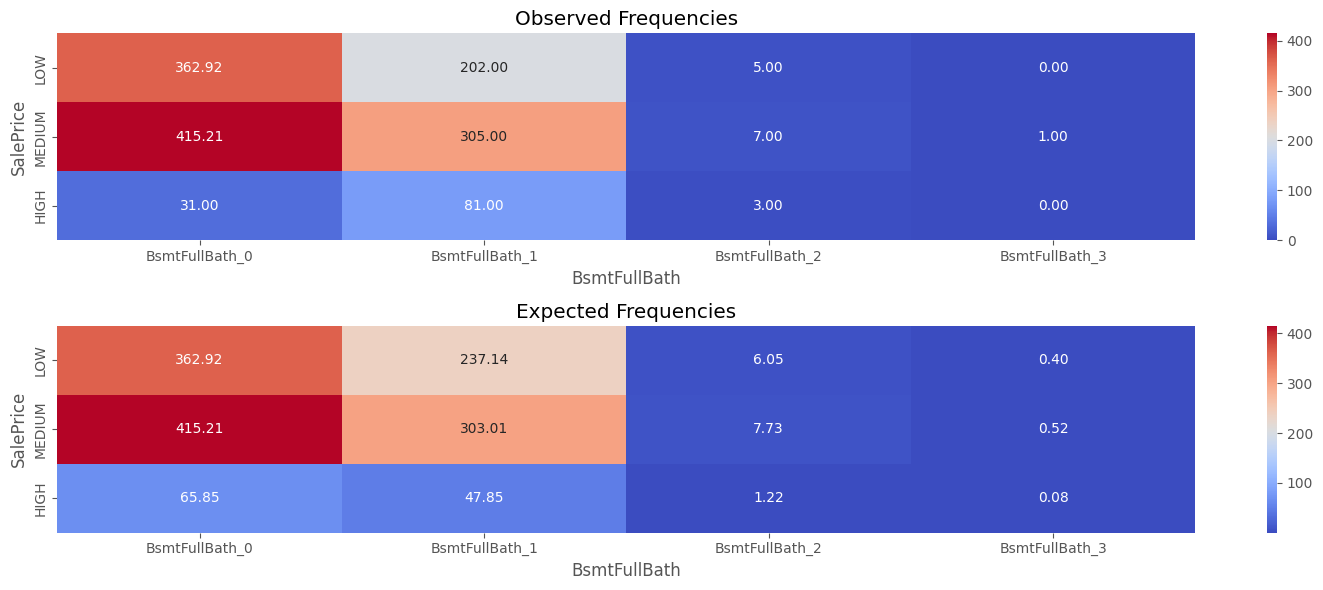

Chi-square Test - Outcome
P-Value: 2.3271572182731895e-12 [<0.05]
0.032819947247596126


c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


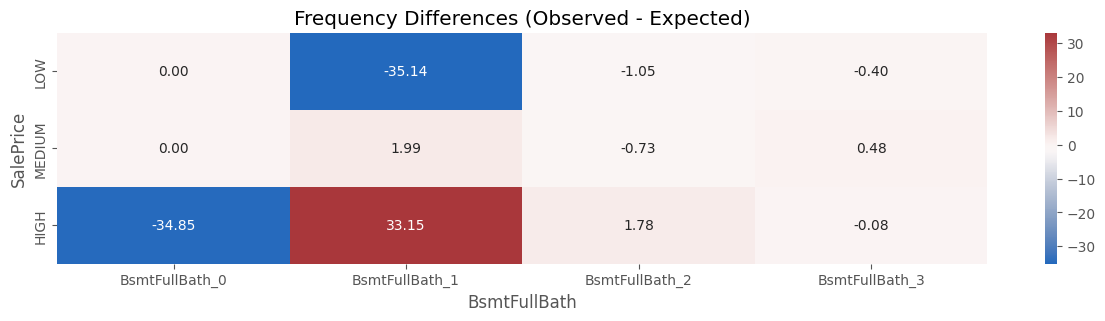

In [46]:
categoric_ordinal_plot(df, 'BsmtFullBath')

##### BsmtHalfBath

SalePrice,LOW,MEDIUM,HIGH
BsmtHalfBath,,,
BsmtHalfBath_0,42.380261,49.492017,8.127721
BsmtHalfBath_1,42.500000,53.750000,3.750000
BsmtHalfBath_2,50.000000,50.000000,0.000000


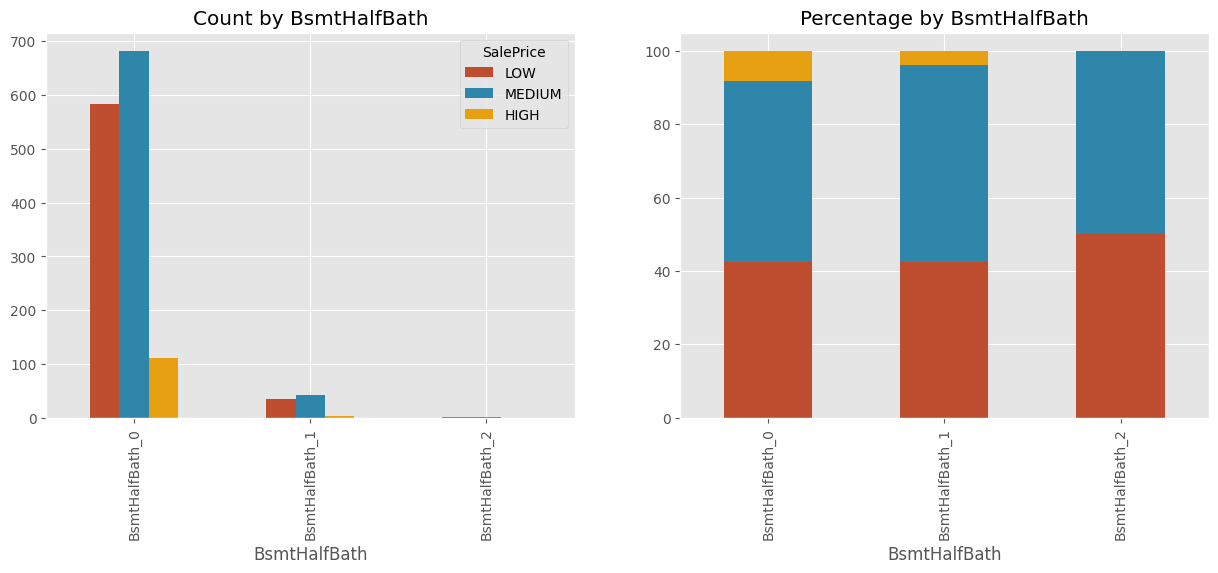

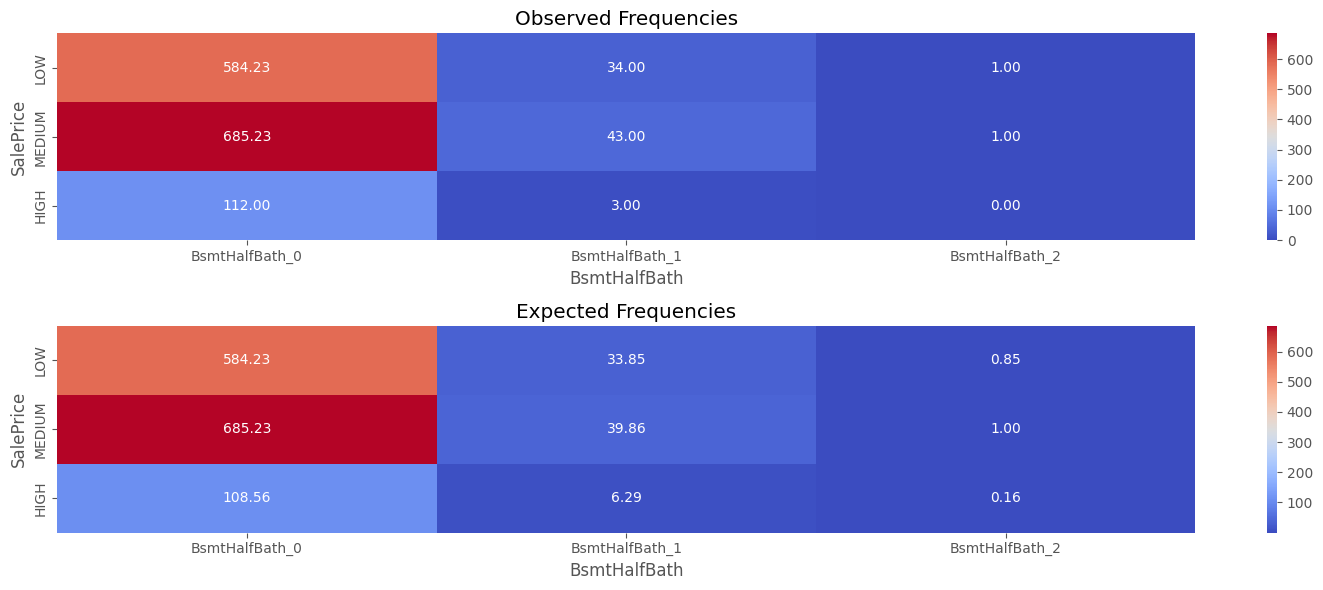

Chi-square Test - Outcome
P-Value: 0.6806487194877051 
0.0014174939544221248


c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


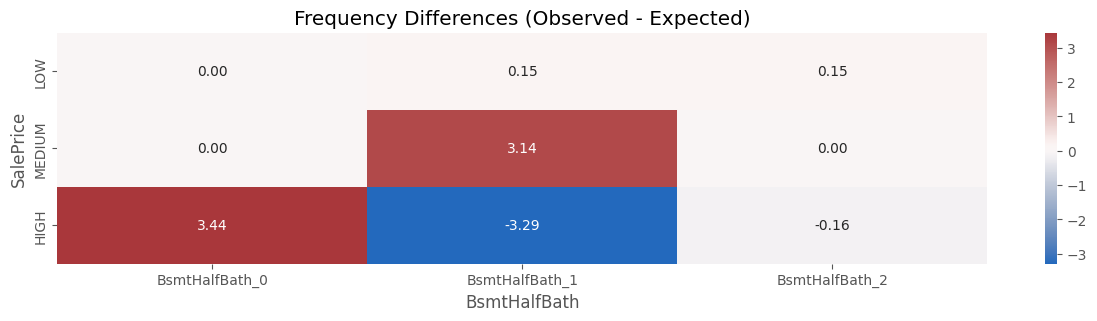

In [47]:
categoric_ordinal_plot(df, 'BsmtHalfBath')

##### FullBath

SalePrice,LOW,MEDIUM,HIGH
FullBath,,,
FullBath_0,55.555556,33.333333,11.111111
FullBath_1,74.923077,24.000000,1.076923
FullBath_2,16.536458,71.875000,11.588542
FullBath_3,0.000000,45.454545,54.545455


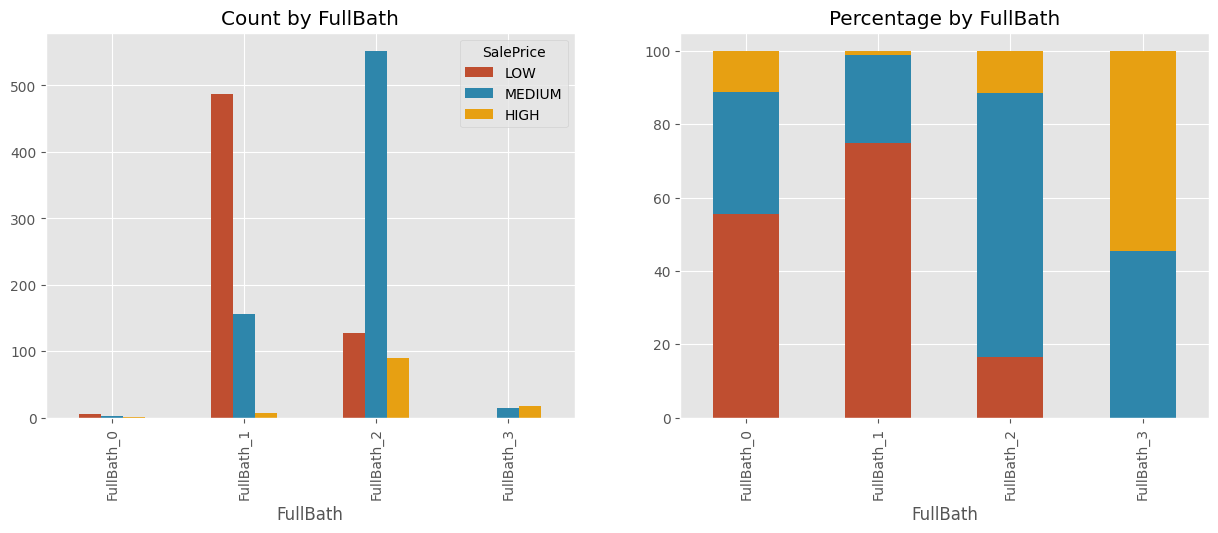

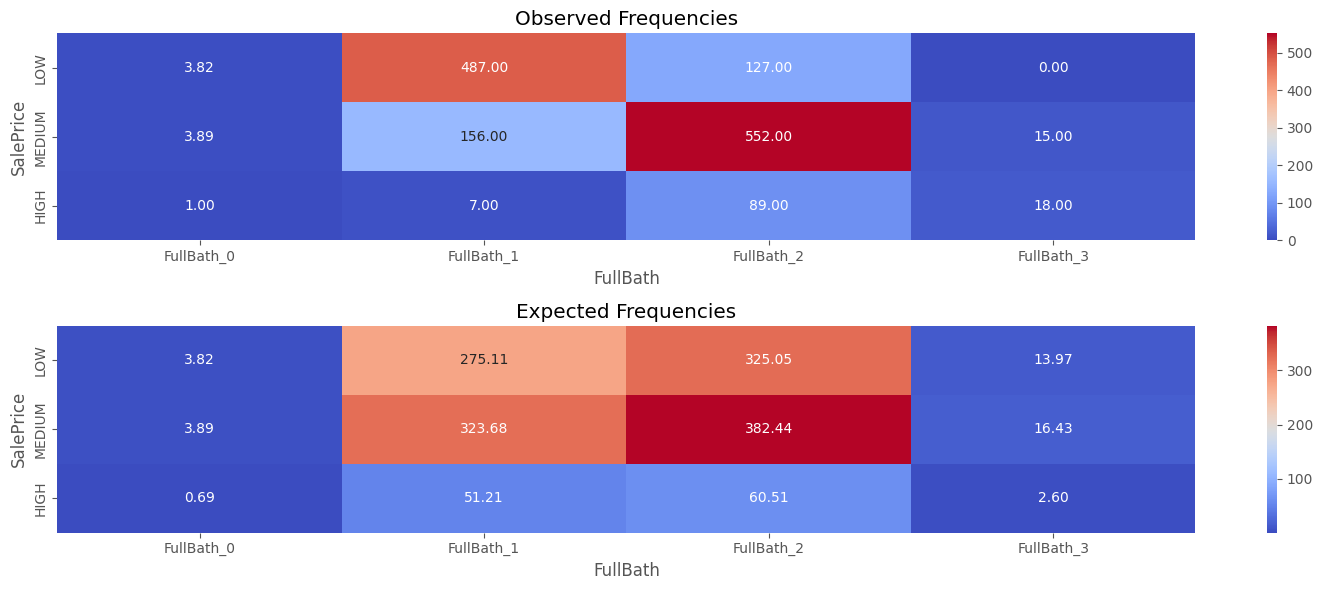

Chi-square Test - Outcome
P-Value: 4.018443251096999e-127 [<0.05]
0.29826715827233946


c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.29826715827233946

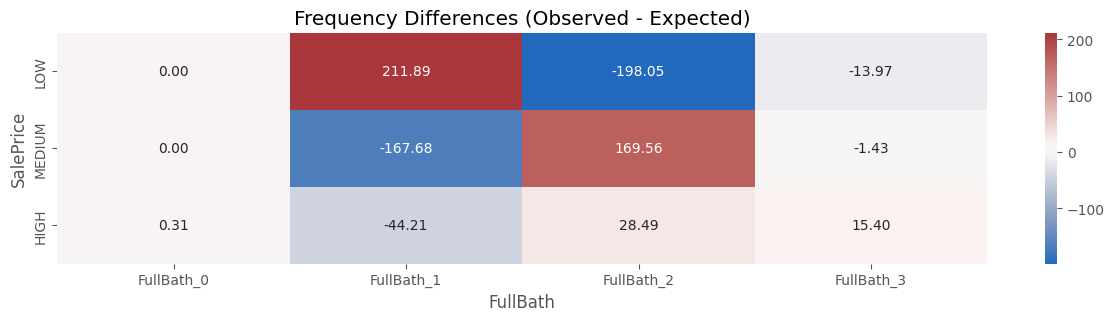

In [48]:
categoric_ordinal_plot(df, 'FullBath')
IG(df, TARGET_FEATURE, 'FullBath')

##### HalfBath

SalePrice,LOW,MEDIUM,HIGH
HalfBath,,,
HalfBath_0,55.969332,39.101862,4.928806
HalfBath_1,19.252336,67.663551,13.084112
HalfBath_2,41.666667,58.333333,0.000000


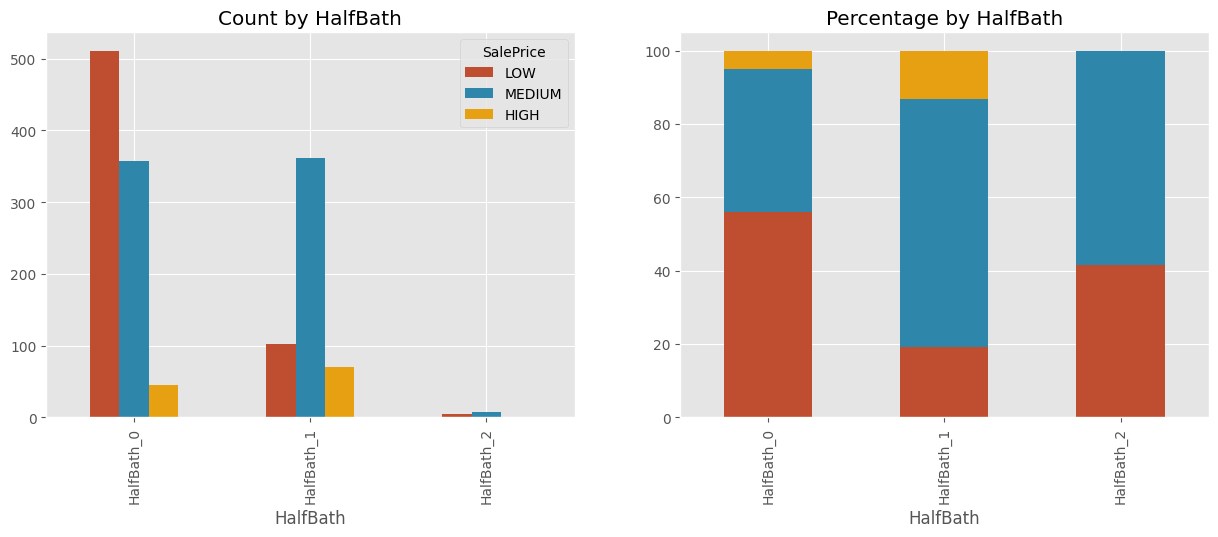

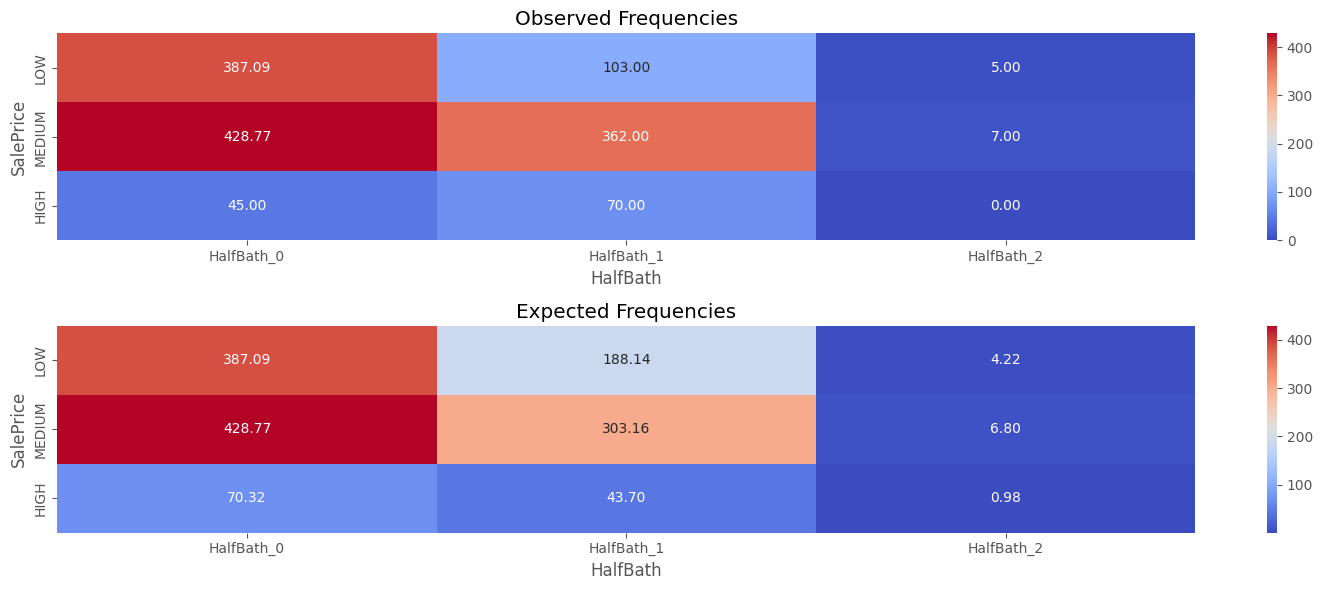

Chi-square Test - Outcome
P-Value: 1.7652372425300367e-40 [<0.05]
0.10054858198695393


c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


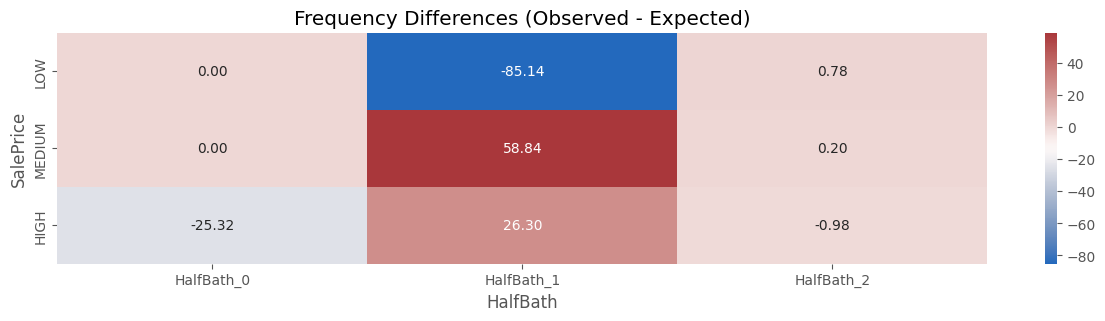

In [49]:
categoric_ordinal_plot(df, 'HalfBath')

##### BedroomAbvGr

SalePrice,LOW,MEDIUM,HIGH
BedroomAbvGr,,,
BedroomAbvGr_0,50.000000,33.333333,16.666667
BedroomAbvGr_1,56.000000,32.000000,12.000000
BedroomAbvGr_2,59.497207,34.357542,6.145251
BedroomAbvGr_3,37.064677,57.089552,5.845771
BedroomAbvGr_4,30.046948,52.582160,17.370892
BedroomAbvGr_5,33.333333,57.142857,9.523810
BedroomAbvGr_6,85.714286,14.285714,0.000000
BedroomAbvGr_8,0.000000,100.000000,0.000000


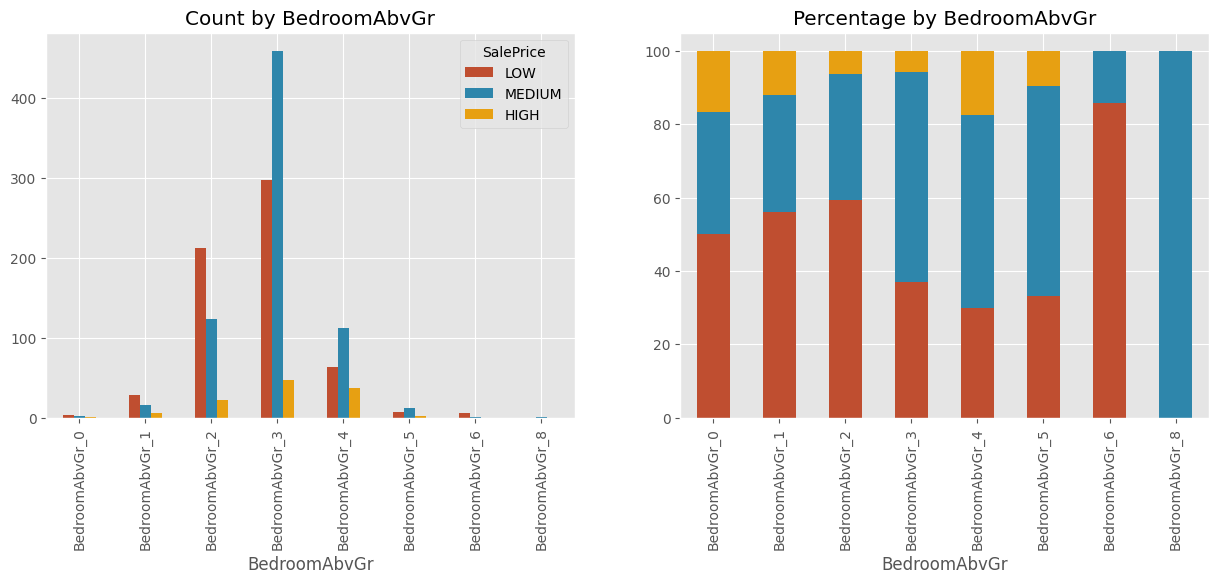

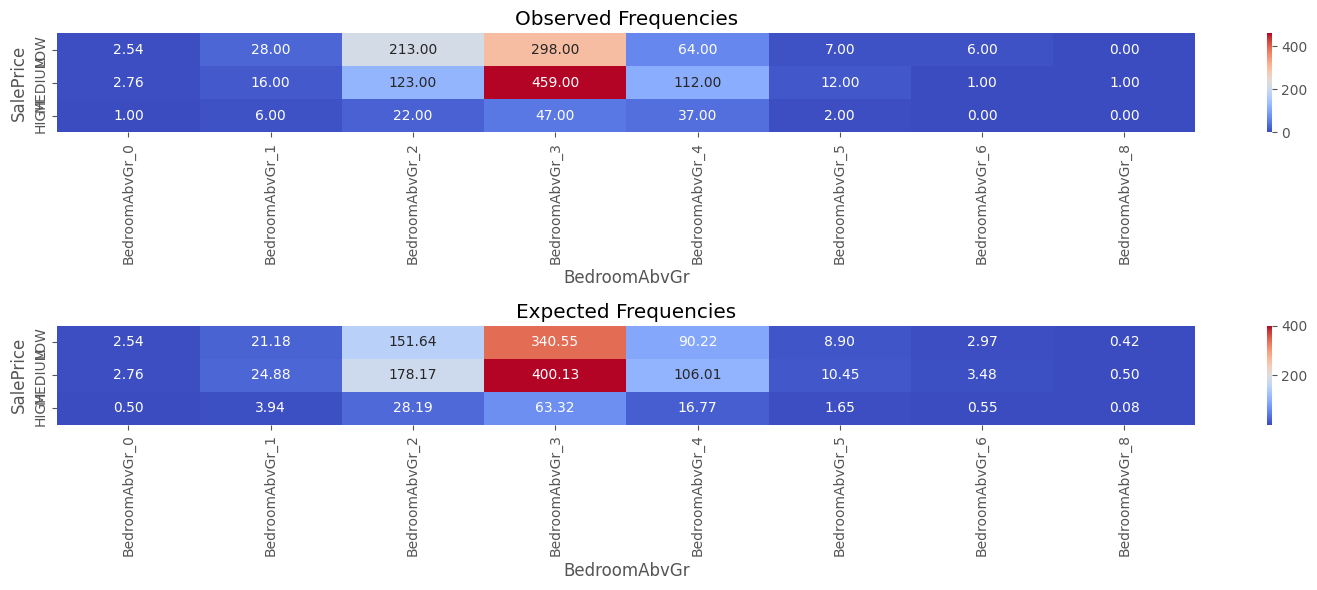

Chi-square Test - Outcome
P-Value: 1.1574262089106492e-16 [<0.05]
0.05116755634206285


c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


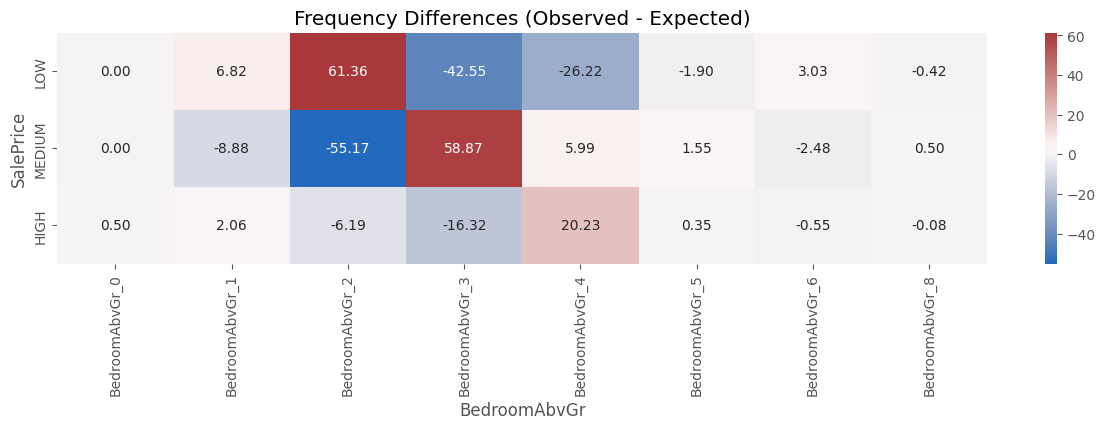

In [50]:
categoric_ordinal_plot(df, 'BedroomAbvGr')

##### KitchenAbvGr

SalePrice,LOW,MEDIUM,HIGH
KitchenAbvGr,,,
KitchenAbvGr_0,100.000000,0.000000,0.000000
KitchenAbvGr_1,40.517241,51.221264,8.261494
KitchenAbvGr_2,80.000000,20.000000,0.000000
KitchenAbvGr_3,100.000000,0.000000,0.000000


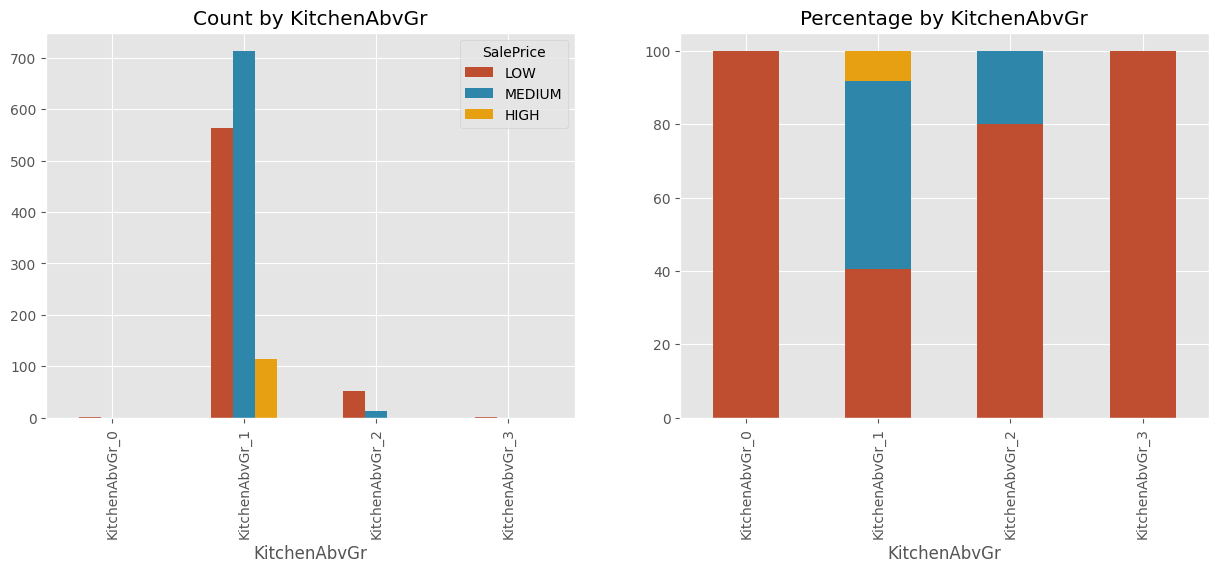

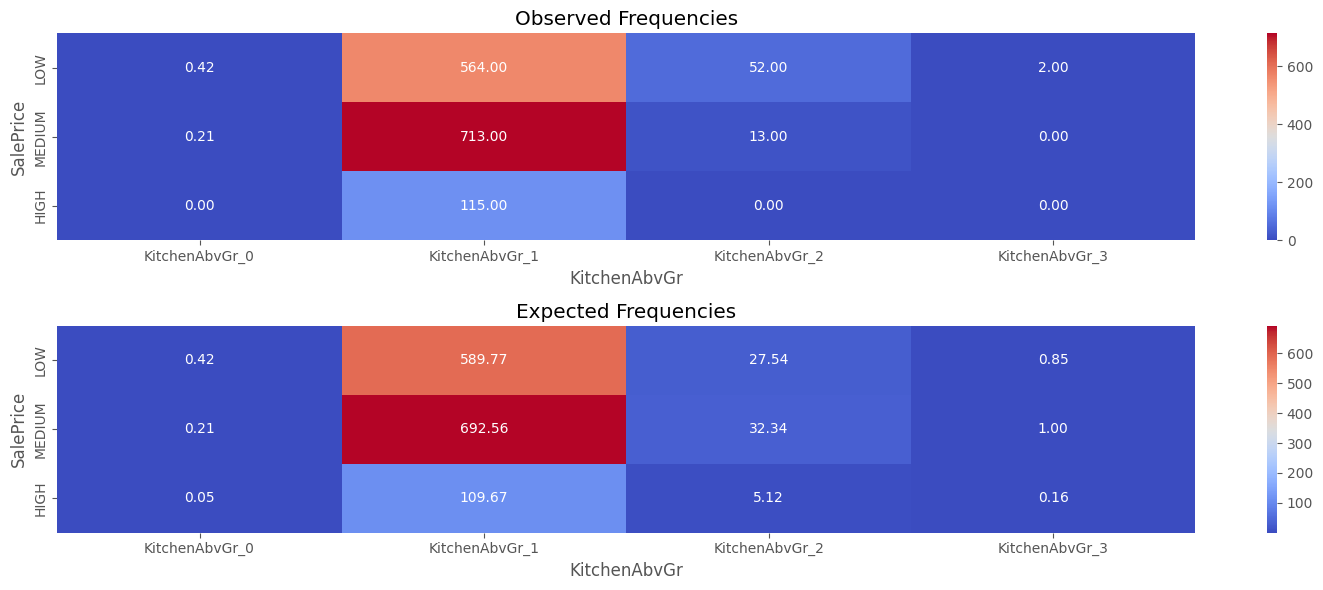

Chi-square Test - Outcome
P-Value: 5.958096086434347e-08 [<0.05]
0.024484826808309997


c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


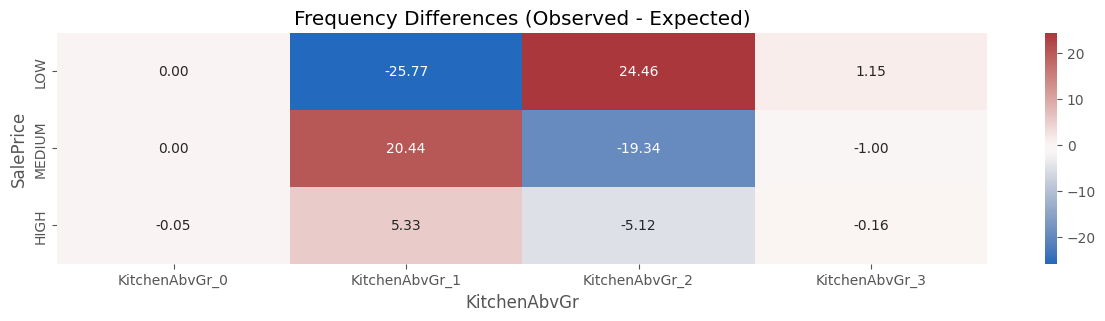

In [51]:
categoric_ordinal_plot(df, 'KitchenAbvGr')

##### KitchenQual

SalePrice,LOW,MEDIUM,HIGH
KitchenQual,,,
Ex,5.000000,38.000000,57.000000
Fa,94.871795,5.128205,0.000000
Gd,14.846416,75.597270,9.556314
TA,66.666667,33.061224,0.272109


c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.3341239388726758

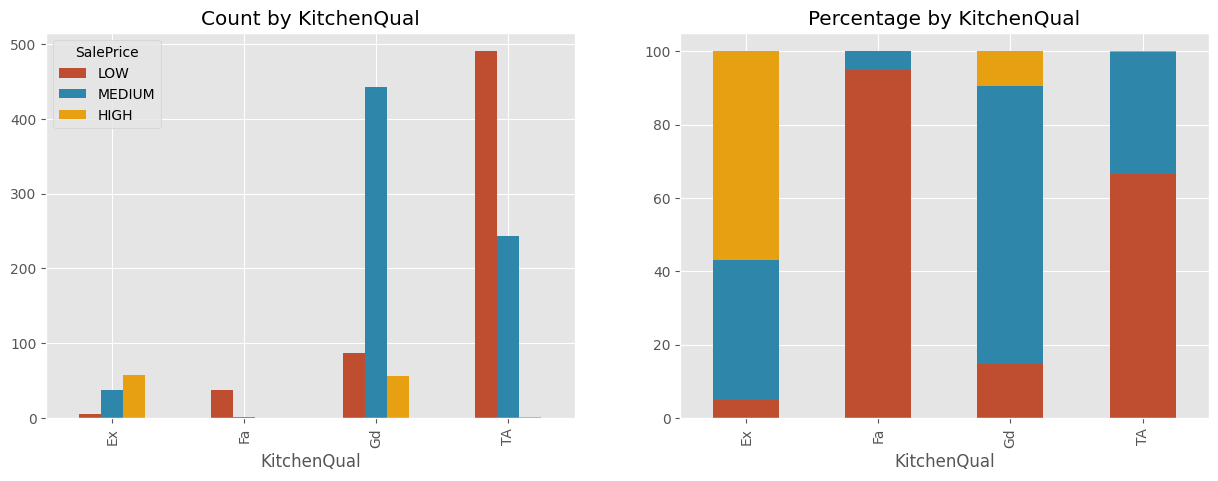

In [52]:
frequencies_and_percentages(df, TARGET_FEATURE, 'KitchenQual')
IG(df, TARGET_FEATURE, 'KitchenQual')

##### TotRmsAbvGrd

SalePrice,LOW,MEDIUM,HIGH
TotRmsAbvGrd,,,
2,100.000000,0.000000,0.000000
3,94.117647,5.882353,0.000000
4,83.505155,16.494845,0.000000
5,70.545455,27.636364,1.818182
6,46.268657,51.990050,1.741294
7,22.796353,70.212766,6.990881
8,21.390374,64.171123,14.438503
9,16.000000,58.666667,25.333333
10,21.276596,34.042553,44.680851


c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ANOVA Test - Outcome
P-Value: 4.972682537673768e-83 [<0.05]


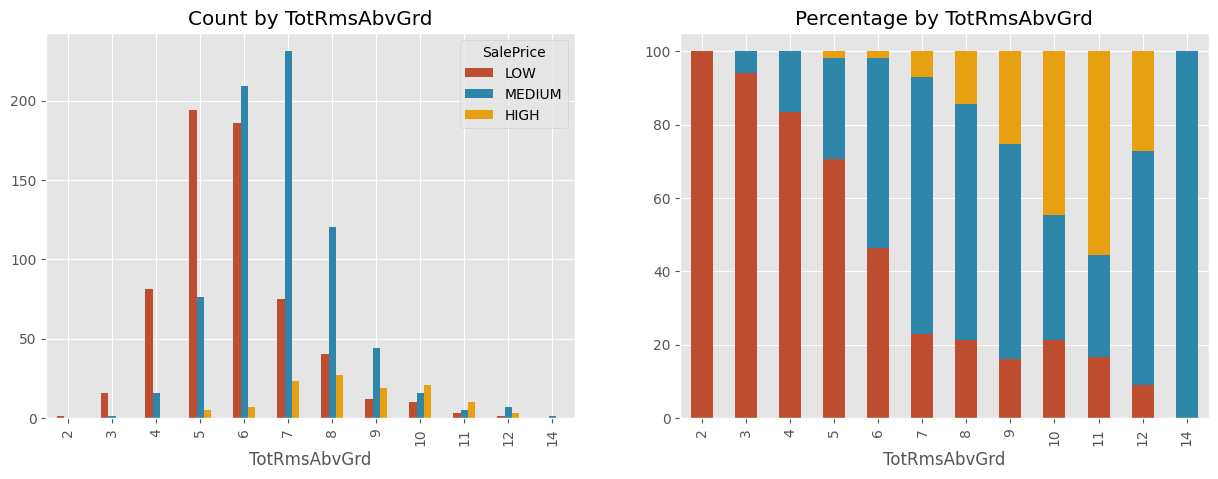

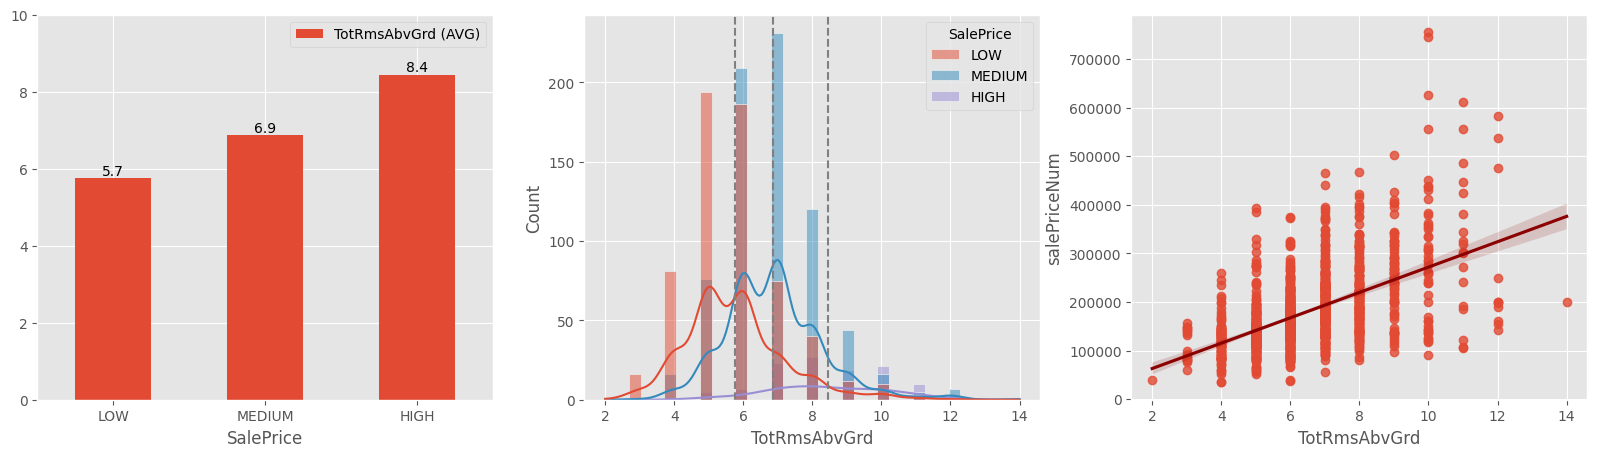

In [53]:
frequencies_and_percentages(df, TARGET_FEATURE, 'TotRmsAbvGrd')
IG(df, TARGET_FEATURE, 'TotRmsAbvGrd')
stattest_quanti(df, 'TotRmsAbvGrd', upper_limit=10)

##### Functional

SalePrice,LOW,MEDIUM,HIGH
Functional,,,
Maj1,57.142857,35.714286,7.142857
Maj2,100.000000,0.000000,0.000000
Min1,61.290323,38.709677,0.000000
Min2,61.764706,35.294118,2.941176
Mod,53.333333,40.000000,6.666667
Sev,100.000000,0.000000,0.000000
Typ,40.955882,50.808824,8.235294


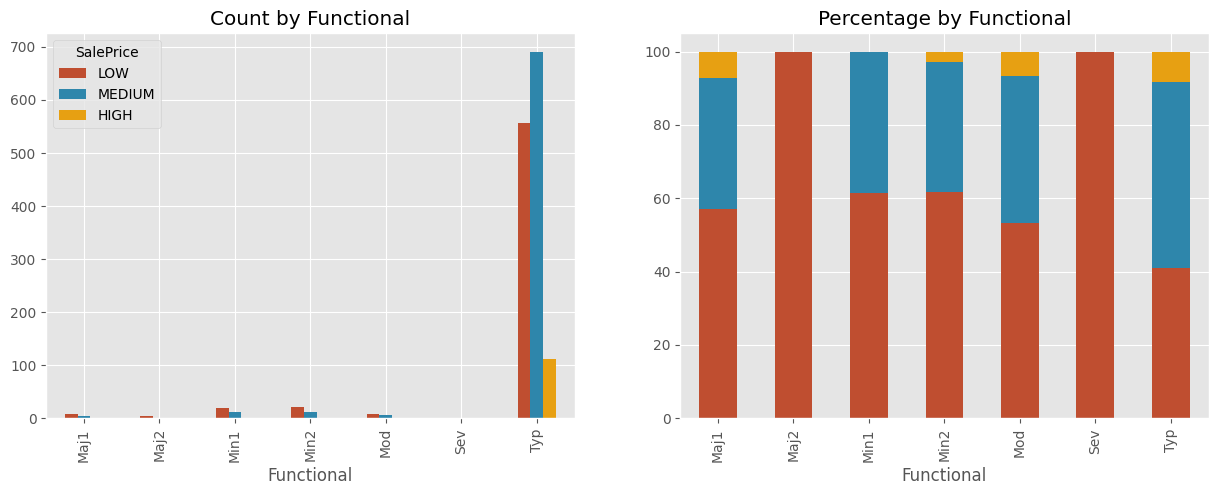

In [54]:
df_copy['Functional'] = df_copy['Functional'].astype('category')
#df_copy['Functional'].unique()
frequencies_and_percentages(df_copy, TARGET_FEATURE, 'Functional')
#stattest_quali(df_copy, 'Functional')

##### Fireplaces

SalePrice,LOW,MEDIUM,HIGH
Fireplaces,,,
Fireplaces_0,66.956522,32.463768,0.579710
Fireplaces_1,21.384615,65.846154,12.769231
Fireplaces_2,15.652174,61.739130,22.608696
Fireplaces_3,0.000000,60.000000,40.000000


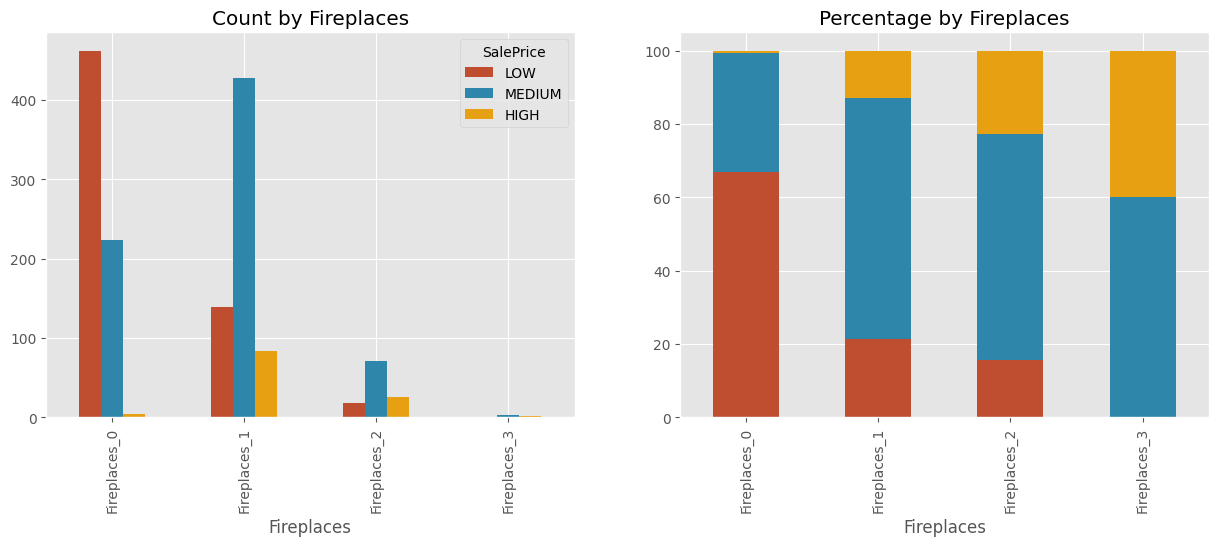

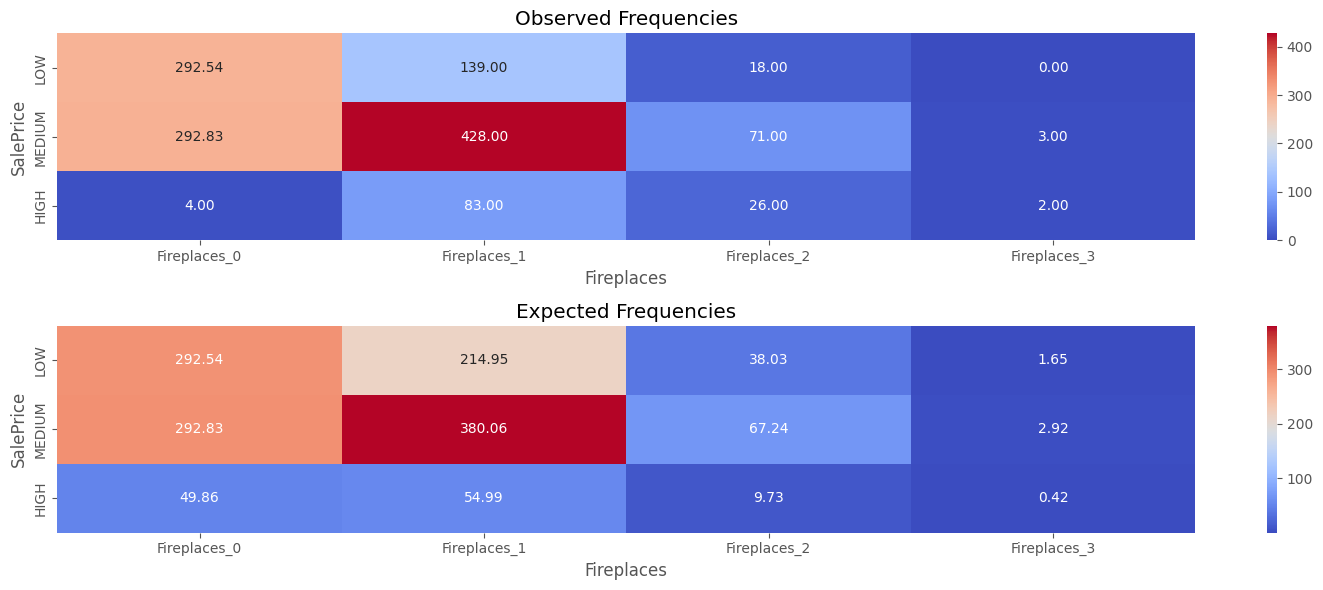

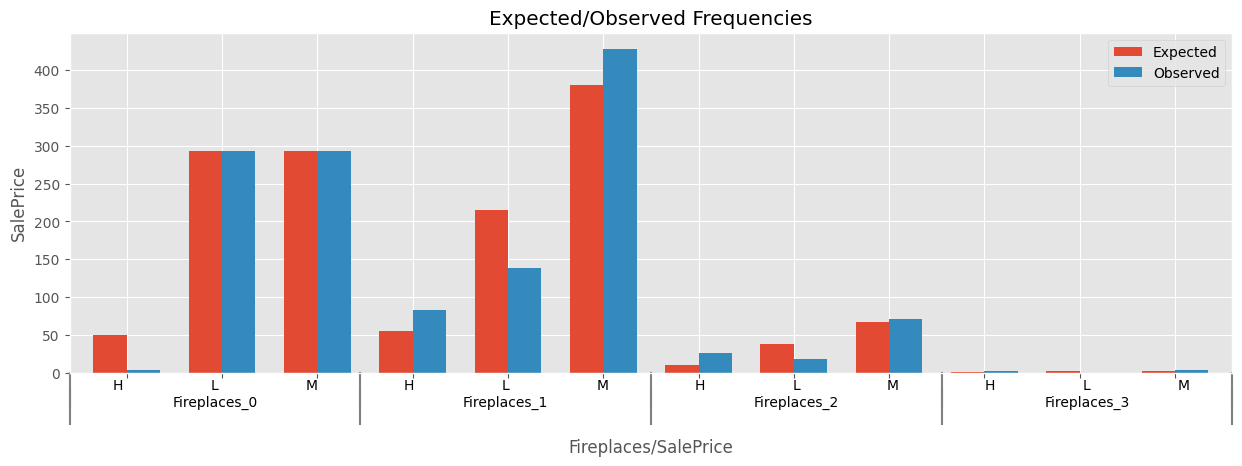

Chi-square Test - Outcome
P-Value: 5.349369497530157e-77 [<0.05]
0.19660718305855462


c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [55]:
categoric_ordinal_plot(df, 'Fireplaces', test_typeplot='barplot')

##### FireplaceQu

SalePrice,LOW,MEDIUM,HIGH
FireplaceQu,,,
Ex,4.166667,33.333333,62.500000
Fa,36.363636,63.636364,0.000000
Gd,21.052632,60.526316,18.421053
NA,66.956522,32.463768,0.579710
Po,75.000000,25.000000,0.000000
TA,15.654952,76.038339,8.306709


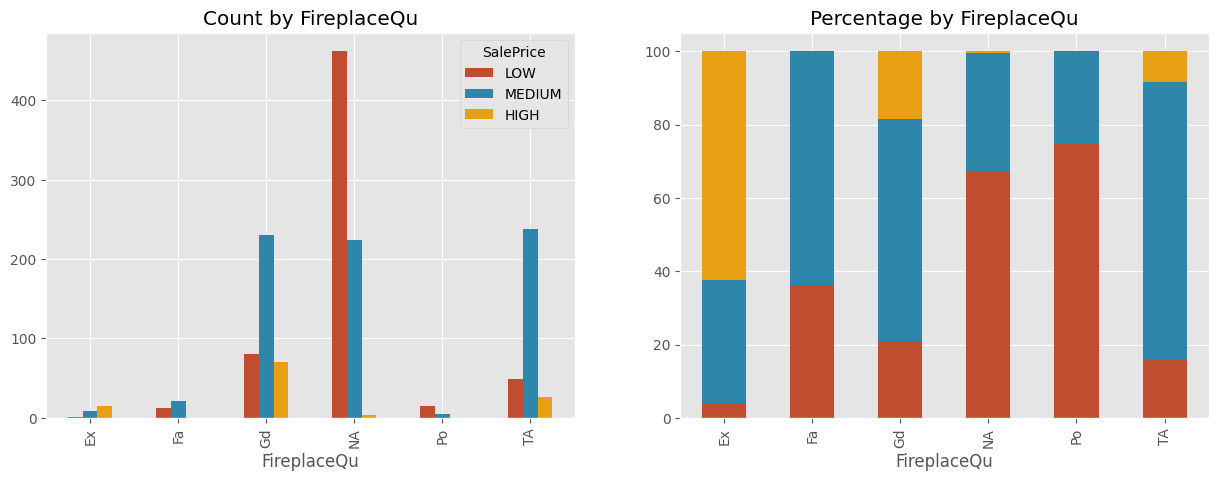

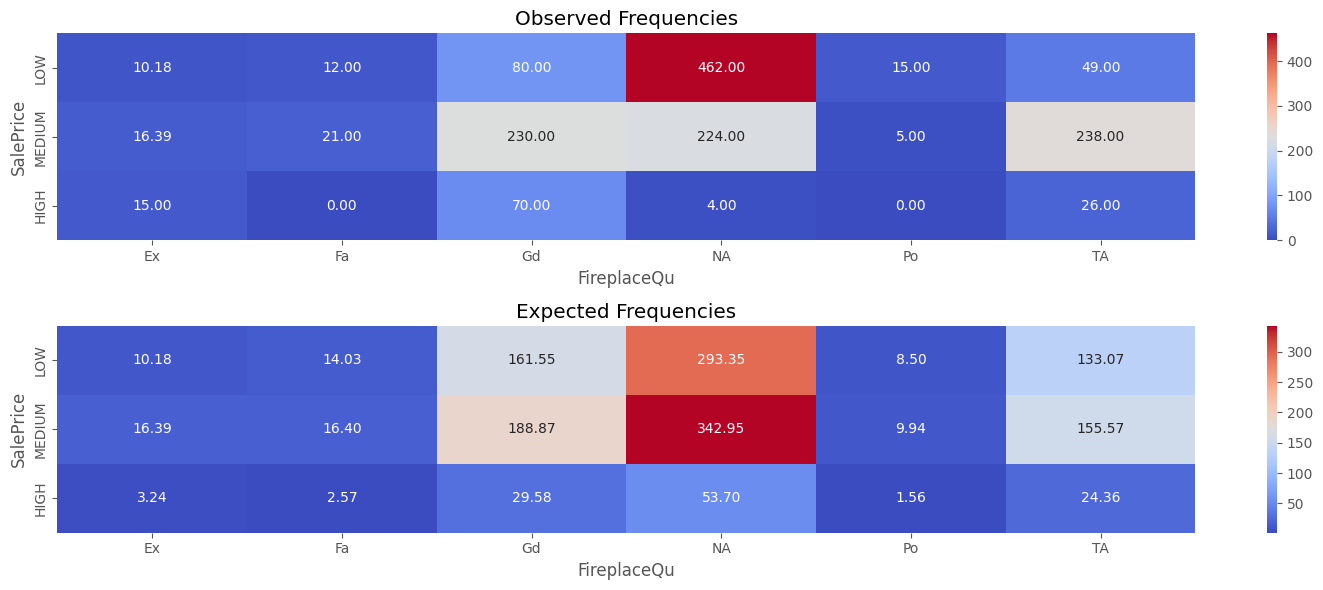

Chi-square Test - Outcome
P-Value: 5.148137174516188e-101 [<0.05]


c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.2386235241672775

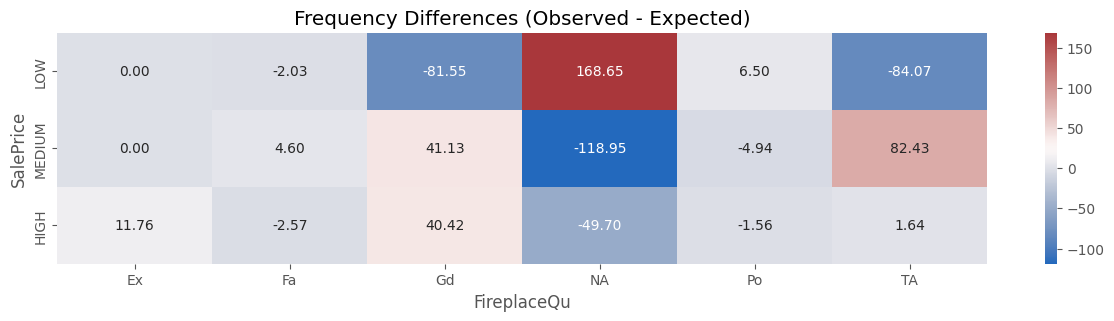

In [56]:
df_copy['FireplaceQu'] = df_copy['FireplaceQu'].astype('category')
frequencies_and_percentages(df_copy, TARGET_FEATURE, 'FireplaceQu')
stattest_quali(df_copy, 'FireplaceQu')
IG(df_copy, TARGET_FEATURE, 'FireplaceQu')

##### GarageType

SalePrice,LOW,MEDIUM,HIGH
GarageType,,,
2Types,50.000000,50.000000,0.000000
Attchd,25.172414,64.597701,10.229885
Basment,52.631579,42.105263,5.263158
BuiltIn,7.954545,67.045455,25.000000
CarPort,88.888889,11.111111,0.000000
Detchd,76.227390,22.997416,0.775194
NA,95.061728,4.938272,0.000000


c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.2403532227920979

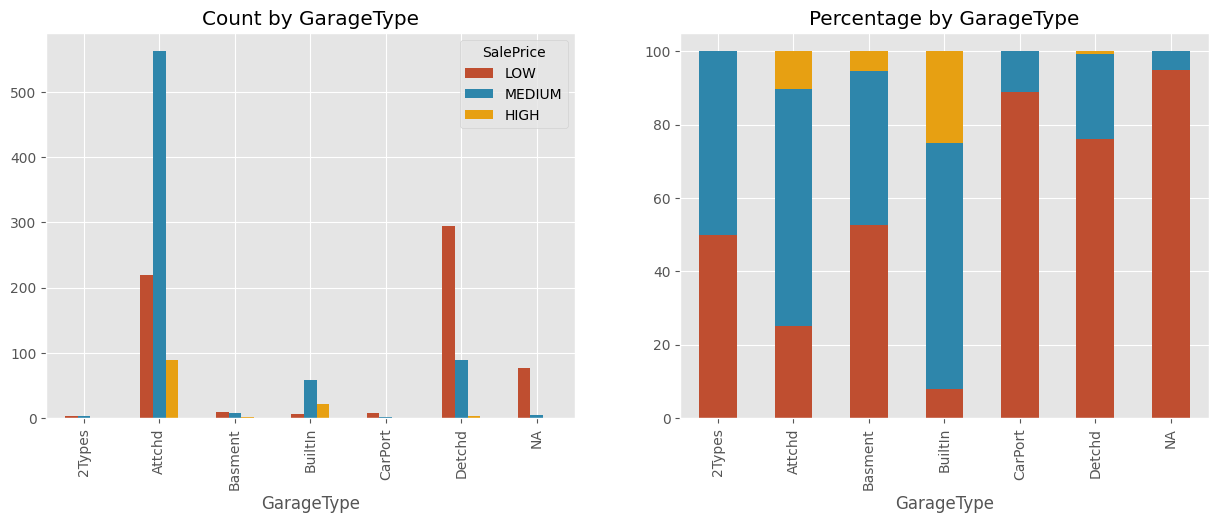

In [57]:
df['GarageType'].unique()
frequencies_and_percentages(df, TARGET_FEATURE, 'GarageType')
IG(df, TARGET_FEATURE, 'GarageType')

##### GarageYrBlt

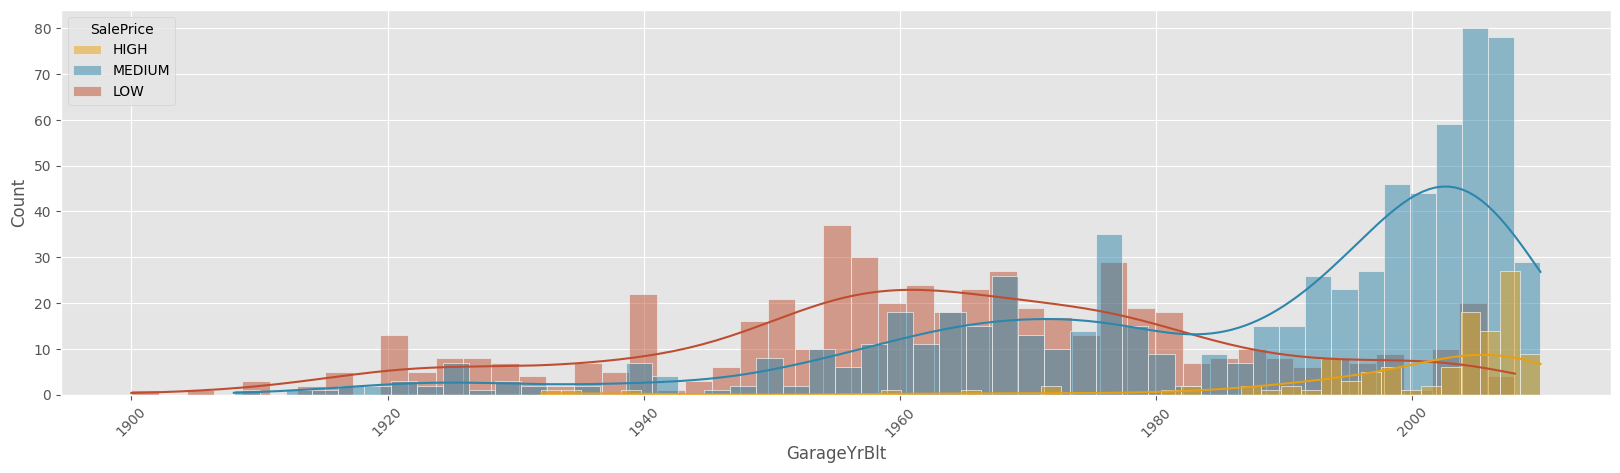

0.8256674841743423 0.0
0.48636167748786086 8.705127942145683e-83


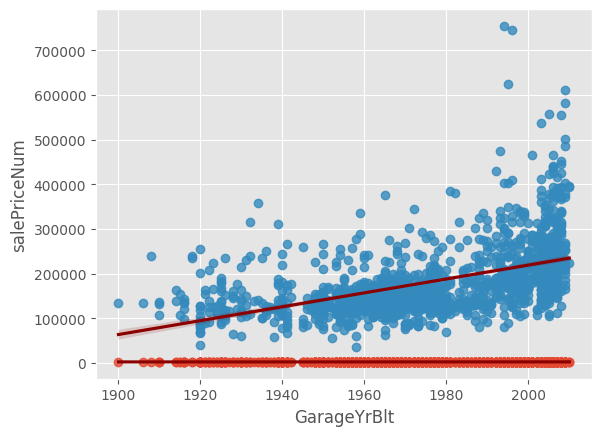

In [58]:
df_copy = df_copy.drop(df_copy[df_copy['GarageYrBlt'] == 'NA'].index)
df_copy['GarageYrBlt'] = df_copy['GarageYrBlt'].astype("int64")

histplot(df_copy, TARGET_FEATURE, 'GarageYrBlt', figsize=(20, 5), xticks_rot=45, bins=50)
correlation(df_copy, 'GarageYrBlt', 'YearBuilt')
correlation(df_copy, 'GarageYrBlt', TARGET_FEATURE_CONTI)

##### GarageFinish

['RFn' 'Unf' 'Fin' 'NA']


SalePrice,LOW,MEDIUM,HIGH
GarageFinish,,,
Fin,11.079545,66.761364,22.159091
NA,95.061728,4.938272,0.000000
RFn,18.957346,74.407583,6.635071
Unf,69.917355,28.595041,1.487603


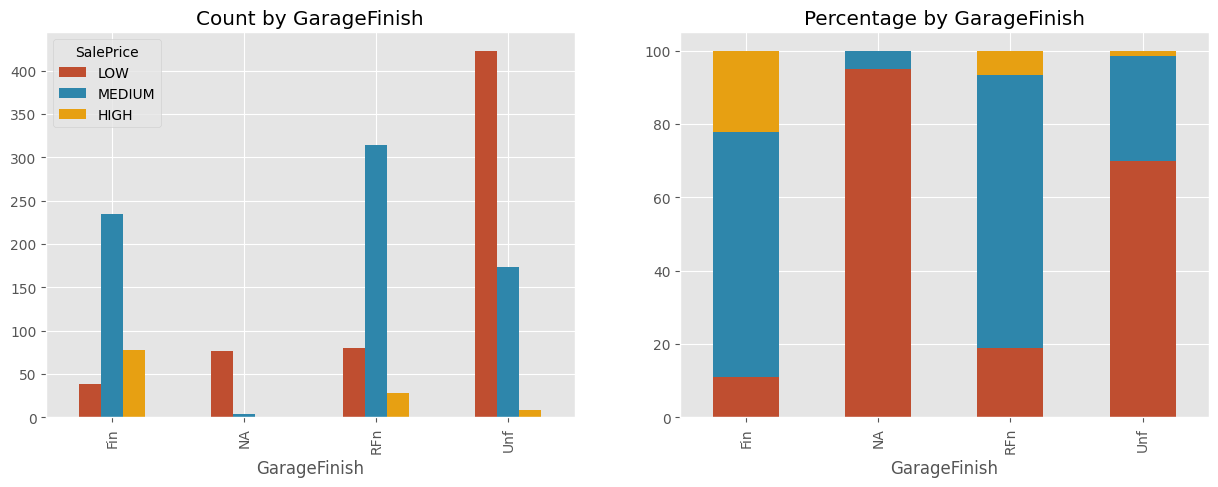

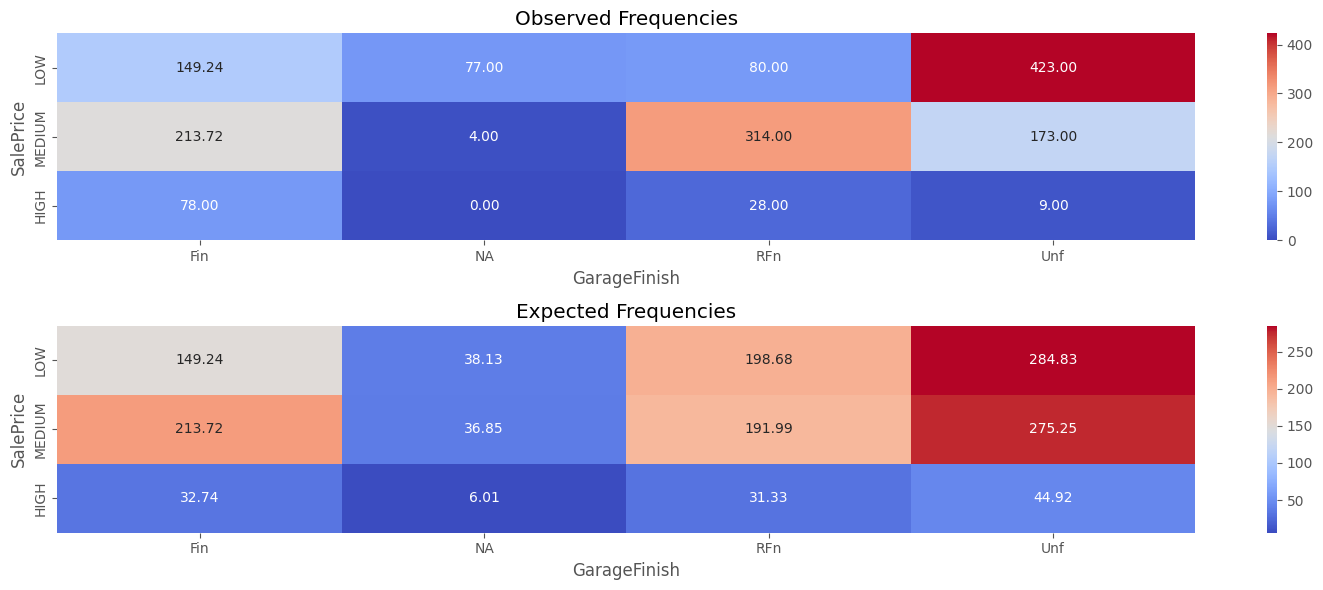

Chi-square Test - Outcome
P-Value: 2.2755608608462434e-123 [<0.05]


c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.3050799574413959

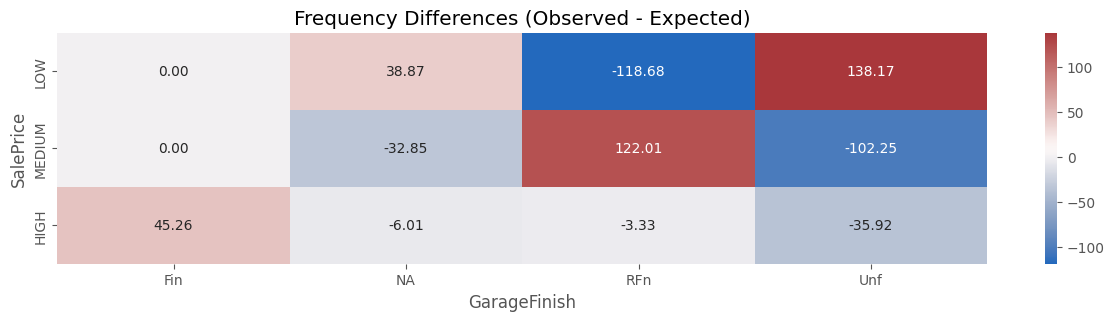

In [59]:
df_copy = df.copy(deep=True)
df_copy['GarageFinish'] = df['GarageFinish']
print(df_copy['GarageFinish'].unique())
df_copy['GarageFinish'] = df_copy['GarageFinish'].astype('category')
frequencies_and_percentages(df_copy, TARGET_FEATURE, 'GarageFinish')
stattest_quali(df_copy, 'GarageFinish')
IG(df_copy, TARGET_FEATURE, 'GarageFinish')

### Data Understanding Tool

SalePrice,LOW,MEDIUM,HIGH
GarageFinish,,,
Fin,11.079545,66.761364,22.159091
NA,95.061728,4.938272,0.000000
RFn,18.957346,74.407583,6.635071
Unf,69.917355,28.595041,1.487603


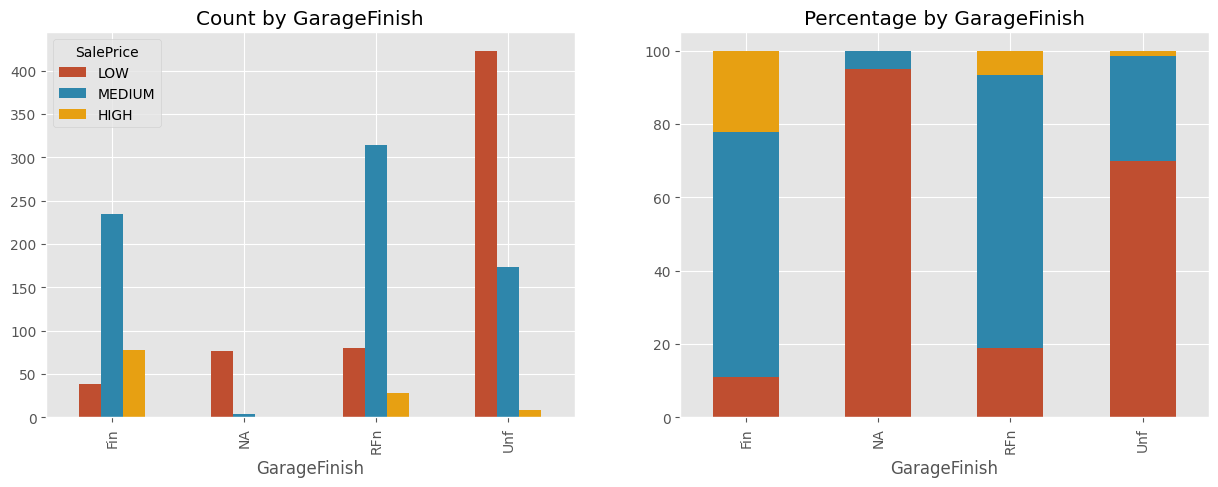

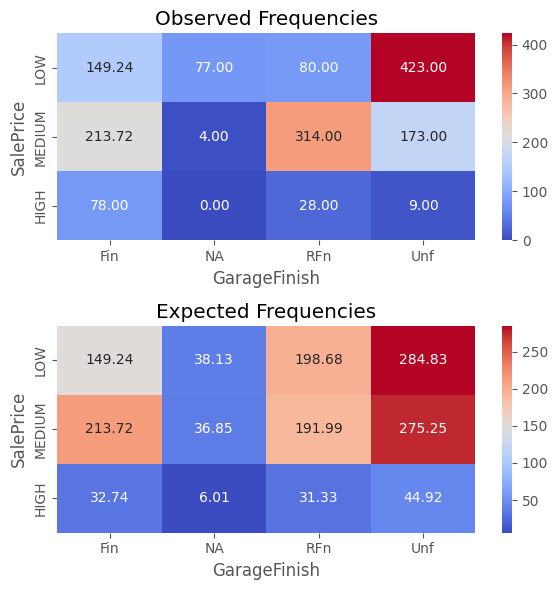

Chi-square Test - Outcome
P-Value: 2.2755608608462434e-123 [<0.05]
Understanding GarageFinish:
	Missing values: 81
	Independence Test: 2.28e-123[<0.05]
	Information Gain: 0.31
	When the GarageFinish is:
		• NA, then the sale price is 95% likely to be LOW (5.55% of the times)
		• RFn, then the sale price is 70% likely to be MEDIUM (28.90% of the times)
		• Fin, then the sale price is 65% likely to be MEDIUM (24.11% of the times)
		• Unf, then the sale price is 65% likely to be LOW (41.44% of the times)




c:\Users\Agostino\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


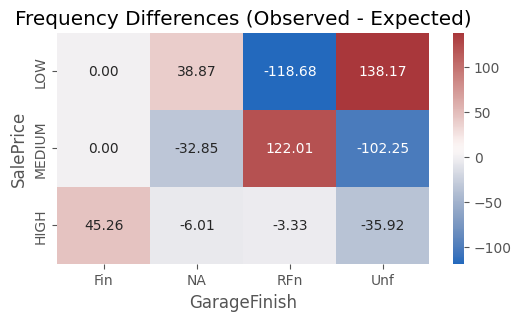

In [74]:
def understand(dataf: pd.DataFrame, feature_name: str, dtype: str=None, \
               predconf_max: float=1.0, predconf_min: float=0.33, showplots=False):
    data_feature = dataf[feature_name]
    data_target = dataf[TARGET_FEATURE]
    report = ''
    report += "Understanding %s:" % feature_name + "\n"

    if showplots:
        frequencies_and_percentages(dataf, TARGET_FEATURE, feature_name)
    
    #
    # count missing values
    #
    miss_values = data_feature.isna().sum()
    miss_values += dataf[data_feature == 'NA'].index.size
    report += "\tMissing values: " + str(miss_values) + "\n"

    data_feature = data_feature.astype(dtype)

    if dtype == 'category':
        #
        # perform the independence test
        #
        p_value, p_value_info = stattest_quali(dataf, feature_name, typeplot='heatmap' if showplots else'none', silent=not showplots)
        report += "\tIndependence Test: " + '{:.2e}'.format(p_value) + p_value_info + "\n"

        #
        # compute the IG
        #
        ig = IG(dataf, TARGET_FEATURE, feature_name)
        report += "\tInformation Gain: " + "%.2f" % ig + "\n"

        crosstab = pd.crosstab(data_feature, data_target)
        to_predict_map = {}
        no_predict_values = []
        for cat_val in crosstab.T:
            no_predict_values.append(cat_val)
        predconf = predconf_max

        while predconf > predconf_min and len(no_predict_values) > 0:
            new_no_predict_values = []

            for cat_val in no_predict_values:
                to_predict = []
                for target_val in TARGET_FEATURE_VALUES:
                    if crosstab.at[cat_val, target_val] / crosstab.loc[cat_val].values.sum() >= predconf:
                        to_predict.append(target_val)
                        to_predict.append(predconf)
                        break
                
                if len(to_predict) > 0:
                    new_to_predict_map = to_predict_map.copy()
                    added = False
                    to_delete = []
                    for k in to_predict_map.keys():
                        if to_predict_map[k] == to_predict:
                            new_to_predict_map[k + '+' + cat_val] = to_predict
                            added = True
                            to_delete.append(k)
                    if not added:
                        new_to_predict_map[cat_val] = to_predict
                    for k in to_delete:
                        del new_to_predict_map[k]
                    to_predict_map = new_to_predict_map
                else:
                    new_no_predict_values.append(cat_val)
            
            no_predict_values = new_no_predict_values
            predconf -= 0.05
        
        report += "\tWhen the %s is:" % feature_name + "\n"
        for cat_vals in to_predict_map.keys():
            if to_predict_map[cat_vals][1] == 1.0:
                report += "\t\t• %s, then the sale price is %s" % (cat_vals, to_predict_map[cat_vals][0])
            else:
                report += "\t\t• %s, then the sale price is %.0f%% likely to be %s" % \
                    (cat_vals, to_predict_map[cat_vals][1]*100, to_predict_map[cat_vals][0])
            
            cat_vals_freq = 0.0
            for cval in cat_vals.split('+'):
                cat_vals_freq += len(dataf[data_feature == cval]) / len(data_feature)
            report += " (%.2f%% of the times)" % (cat_vals_freq*100) + "\n"

        if len(no_predict_values) > 0:
            report += "\t\t• %s cannot predict the sale price" % '+'.join(no_predict_values) + "\n"
        report += "\n"

        return report, ig, p_value

features = df_copy.columns
repos = []
for f in features:
    if df_copy[f].dtype == 'object':
        repo, ig, p_value = understand(df_copy, f, 'category')
        repos.append((ig, p_value, repo))
repos.sort(reverse=True)
for r in repos:
    print(r[2])

repo, ig, p_value = understand(df_copy, 'GarageFinish', 'category', showplots=True)
print(repo)